/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


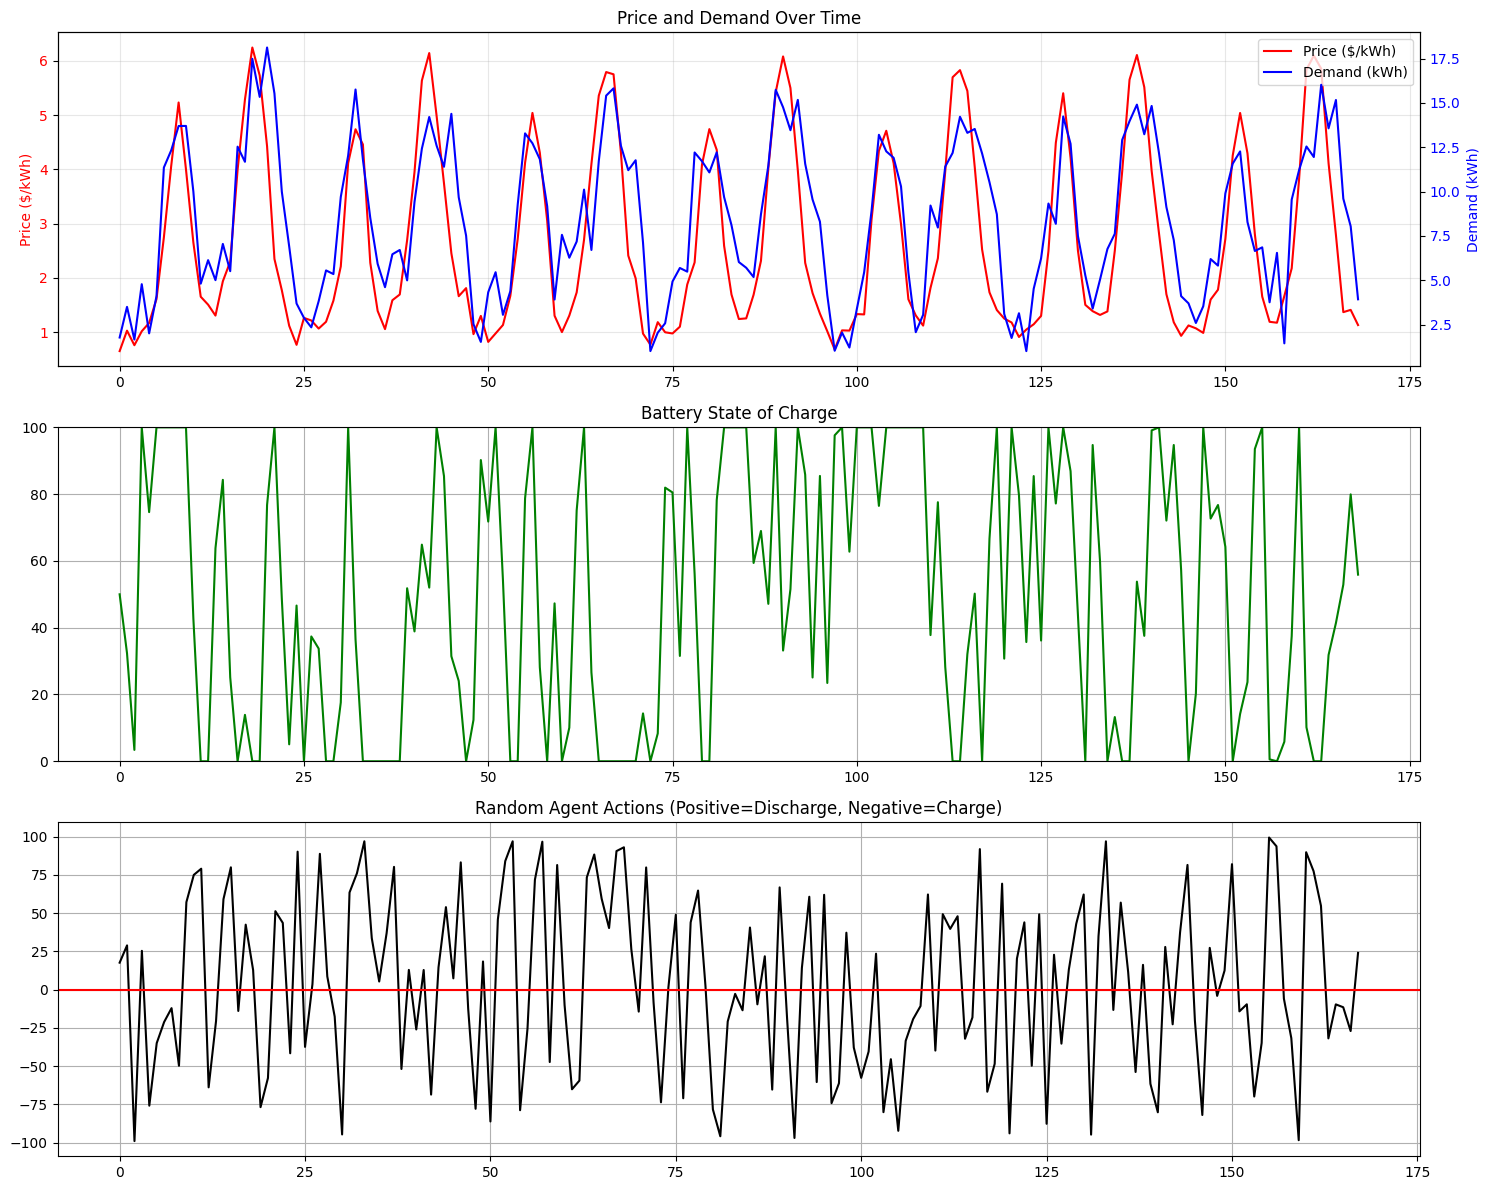

Total reward for random agent: 4601.15


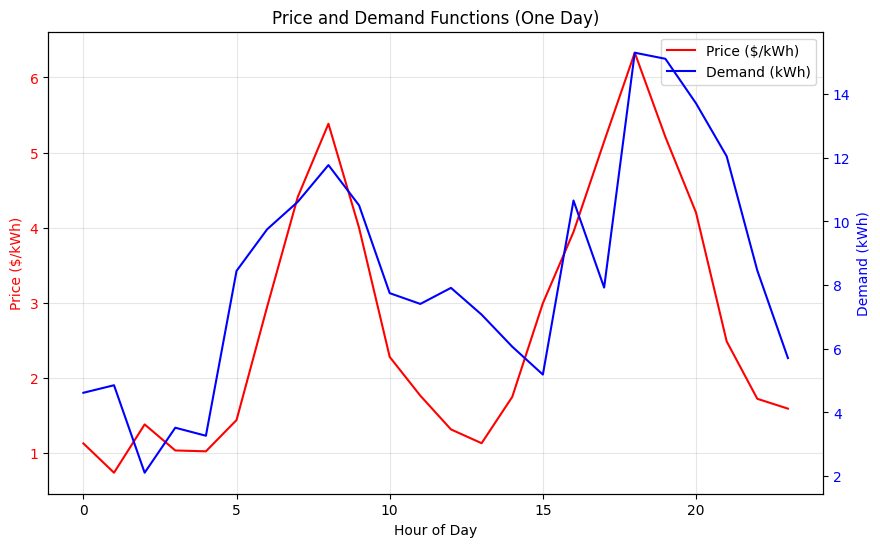

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces

class ElectricityMarketEnv(gym.Env):
    """
    Custom Environment for electricity market with battery storage system.

    State Space:
    - SoC: State of Charge of the battery [0, Capacity]
    - Dt: Demand of electricity (household consumption) [0, ∞)
    - Pt: Price of electricity [0, ∞)

    Action Space:
    - Continuous action space for charging/discharging the battery
    - Range: [-Battery Capacity, Battery Capacity]
    - Negative values mean charging, positive values mean discharging
    """

    def __init__(self, battery_capacity=100, max_steps=24*30, render_mode=None):
        super(ElectricityMarketEnv, self).__init__()

        self.battery_capacity = battery_capacity
        self.max_steps = max_steps  # 24 hours * 30 days by default
        self.current_step = 0
        self.render_mode = render_mode

        # Define action space: charging/discharging battery
        self.action_space = spaces.Box(
            low=-self.battery_capacity,
            high=self.battery_capacity,
            shape=(1,),
            dtype=np.float32
        )

        # Define observation space
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),  # Min values for SoC, Demand, Price
            high=np.array([self.battery_capacity, np.inf, np.inf]),  # Max values
            dtype=np.float32
        )

        # Initialize state
        self.state = None

        # For rendering
        self.price_history = []
        self.demand_history = []
        self.action_history = []
        self.soc_history = []
        self.reward_history = []
        self.profit_history = []

    def _get_price(self, step):
        """
        Model electricity price with two daily peaks and noise.
        Price is higher during peak hours (morning and evening).
        """
        # Convert step to hour of day (0-23)
        hour = step % 24

        # Base price function with two peaks (morning and evening)
        morning_peak = 4 * np.exp(-((hour - 8) ** 2) / (2 * (1.5 ** 2)))
        evening_peak = 5 * np.exp(-((hour - 18) ** 2) / (2 * (2 ** 2)))
        base_price = 1 + morning_peak + evening_peak

        # Add random noise
        noise = np.random.normal(0, 0.2)
        price = max(0.5, base_price + noise)  # Ensure minimum price of 0.5

        return price

    def _get_demand(self, step):
        """
        Model electricity demand with two daily peaks and noise.
        Demand is higher during peak hours (morning and evening).
        """
        # Convert step to hour of day (0-23)
        hour = step % 24

        # Base demand function with two peaks (morning and evening)
        morning_peak = 10 * np.exp(-((hour - 8) ** 2) / (2 * (2 ** 2)))
        evening_peak = 12 * np.exp(-((hour - 19) ** 2) / (2 * (3 ** 2)))
        base_demand = 3 + morning_peak + evening_peak

        # Add random noise
        noise = np.random.normal(0, 1.5)
        demand = max(1, base_demand + noise)  # Ensure minimum demand of 1

        return demand

    def reset(self, seed=None, options=None):
        """
        Reset the environment to an initial state.
        """
        super().reset(seed=seed)

        # Reset state: [SoC, Demand, Price]
        self.state = np.array([
            self.battery_capacity / 2,  # Start with half battery
            self._get_demand(0),        # Initial demand
            self._get_price(0)          # Initial price
        ], dtype=np.float32)

        self.current_step = 0

        # Reset histories for rendering
        self.price_history = [self.state[2]]
        self.demand_history = [self.state[1]]
        self.action_history = []
        self.soc_history = [self.state[0]]
        self.reward_history = []
        self.profit_history = []

        # Return the initial state and info
        info = {}
        return self.state, info

    def step(self, action):
        """
        Take a step in the environment with the given action.

        Args:
            action: Battery charging/discharging action
                   Negative value: charge battery
                   Positive value: discharge battery

        Returns:
            observation: Next state
            reward: Reward for the action
            terminated: Whether the episode is done
            truncated: Whether the episode was truncated
            info: Additional information
        """
        # Ensure action is within bounds
        action = np.clip(action, self.action_space.low, self.action_space.high)[0]
        self.action_history.append(action)

        # Unpack current state
        soc, demand, price = self.state

        # Calculate new SoC based on action
        # Negative action = charge, positive action = discharge
        new_soc = soc - action  # Subtract because positive action means discharge

        # Ensure SoC stays within bounds
        new_soc = np.clip(new_soc, 0, self.battery_capacity)

        # The actual action taken (might be different due to SoC constraints)
        actual_action = soc - new_soc

        # Calculate profit (for tracking/evaluation) - ONLY from selling to grid
        profit = 0
        power_to_grid = 0

        if actual_action > 0:  # Discharging
            # First meet household demand
            power_to_demand = min(actual_action, demand)
            # Sell excess to grid
            power_to_grid = max(0, actual_action - demand)

            # Profit is ONLY from selling excess to grid
            profit = power_to_grid * price

        # Note: When charging (actual_action < 0), profit remains 0
        self.profit_history.append(profit)

        # Calculate reward (modified for learning - relative to average price)
        # For discharging: reward based on price relative to average
        if actual_action > 0:
            #reward = power_to_grid * price
            reward = (power_to_grid * price).item()
        else:  # For charging: zero reward
            reward = 0
        self.reward_history.append(reward)

        # Move to next time step
        self.current_step += 1

        # Update state: new SoC, new demand, new price
        new_demand = self._get_demand(self.current_step)
        new_price = self._get_price(self.current_step)

        self.state = np.array([new_soc.item(), new_demand, new_price], dtype=np.float32)

        # Store for rendering
        self.soc_history.append(new_soc)
        self.price_history.append(new_price)
        self.demand_history.append(new_demand)

        # Check if episode is done
        terminated = False
        truncated = self.current_step >= self.max_steps

        # Additional info
        info = {
            'step': self.current_step,
            'actual_action': actual_action,
            'power_to_grid': power_to_grid if actual_action > 0 else 0,
            'demand': demand,
            'price': price,
            'profit': profit,
            'total_profit': sum(self.profit_history)
        }

        return self.state, reward, terminated, truncated, info

    def render(self):
        """
        Render the environment.
        """
        if self.render_mode == "human":
            self._plot_state()

    def _plot_state(self):
        """
        Plot the current state of the environment.
        """
        plt.figure(figsize=(15, 12))

        # Plot price and demand with dual y-axes
        ax1 = plt.subplot(4, 1, 1)
        plt.title('Price and Demand Over Time')

        # Price on left y-axis
        line1, = ax1.plot(self.price_history, 'r-', label='Price ($/kWh)')
        ax1.set_ylabel('Price ($/kWh)', color='r')
        ax1.tick_params(axis='y', labelcolor='r')
        ax1.grid(True, alpha=0.3)

        # Demand on right y-axis
        ax2 = ax1.twinx()
        line2, = ax2.plot(self.demand_history, 'b-', label='Demand (kWh)')
        ax2.set_ylabel('Demand (kWh)', color='b')
        ax2.tick_params(axis='y', labelcolor='b')

        # Combined legend
        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc='upper right')

        # Plot battery SoC
        plt.subplot(4, 1, 2)
        plt.title('Battery State of Charge')
        plt.plot(self.soc_history, 'g-')
        plt.ylim(0, self.battery_capacity)
        plt.grid(True)

        # Plot actions
        plt.subplot(4, 1, 3)
        plt.title('Agent Actions (Positive=Discharge, Negative=Charge)')
        plt.plot(self.action_history, 'k-')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.grid(True)

        # Plot profit and reward
        plt.subplot(4, 1, 4)
        plt.title('Profit vs Learning Reward')
        plt.plot(self.profit_history, 'g-', label='Actual Profit')
        plt.plot(self.reward_history, 'b-', label='Learning Reward')
        plt.axhline(y=0, color='r', linestyle='-')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

def plot_random_agent(env, num_steps=24*7):
    """
    Run a random agent on the environment and plot the results.

    Args:
        env: The environment
        num_steps: Number of steps to run
    """
    # Reset the environment
    state, _ = env.reset()

    # Run random agent
    total_reward = 0
    for _ in range(num_steps):
        # Sample random action
        action = env.action_space.sample()
        # Take step
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    # Plot results
    plt.figure(figsize=(15, 12))

    # Plot price and demand with dual y-axes
    ax1 = plt.subplot(3, 1, 1)
    plt.title('Price and Demand Over Time')

    # Price on left y-axis
    line1, = ax1.plot(env.price_history, 'r-', label='Price ($/kWh)')
    ax1.set_ylabel('Price ($/kWh)', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.grid(True, alpha=0.3)

    # Demand on right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(env.demand_history, 'b-', label='Demand (kWh)')
    ax2.set_ylabel('Demand (kWh)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Combined legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    # Plot battery SoC
    plt.subplot(3, 1, 2)
    plt.title('Battery State of Charge')
    plt.plot(env.soc_history, 'g-')
    plt.ylim(0, env.battery_capacity)
    plt.grid(True)

    # Plot actions
    plt.subplot(3, 1, 3)
    plt.title('Random Agent Actions (Positive=Discharge, Negative=Charge)')
    plt.plot(env.action_history, 'k-')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Total reward for random agent: {total_reward:.2f}")

# Test the environment with a random agent
if __name__ == "__main__":
    # Create the environment
    env = ElectricityMarketEnv(battery_capacity=100, max_steps=24*7)

    # Run and plot random agent
    plot_random_agent(env)

    # Plot price and demand functions for one day
    hours = np.arange(24)
    prices = [env._get_price(h) for h in hours]
    demands = [env._get_demand(h) for h in hours]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.title('Price and Demand Functions (One Day)')

    # Price on left y-axis
    line1, = ax1.plot(hours, prices, 'r-', label='Price ($/kWh)')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Price ($/kWh)', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.grid(True, alpha=0.3)

    # Demand on right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(hours, demands, 'b-', label='Demand (kWh)')
    ax2.set_ylabel('Demand (kWh)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Combined legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')
    plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import random

class DQNAgent:
    """
    Deep Q-Network agent for the electricity market environment.

    Since the original environment has a continuous action space,
    we discretize it for the DQN agent.
    """

    def __init__(self, state_size, action_size, battery_capacity, learning_rate=0.001,
                 gamma=0.99, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.05,
                 batch_size=64, memory_size=10000):
        """
        Initialize the DQN agent.

        Args:
            state_size: Dimension of state space
            action_size: Dimension of action space (after discretization)
            battery_capacity: Maximum battery capacity
            learning_rate: Learning rate for optimizer
            gamma: Discount factor
            epsilon: Exploration rate
            epsilon_decay: Rate to decrease epsilon
            epsilon_min: Minimum epsilon value
            batch_size: Batch size for training
            memory_size: Size of replay memory
        """
        self.state_size = state_size
        self.action_size = action_size
        self.battery_capacity = battery_capacity

        # Define action space discretization
        self.actions = np.linspace(-battery_capacity, battery_capacity, action_size)

        # Learning parameters
        self.learning_rate = learning_rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size

        # Replay memory
        self.memory = deque(maxlen=memory_size)

        # Build model
        self.model = self._build_model()
        self.target_model = self._build_model()

        # Initialize target model with same weights
        self.update_target_model()

    def _build_model(self):
        """
        Build the neural network model.
        """
        model = keras.Sequential([
            keras.layers.Dense(32, activation='relu', input_shape=(self.state_size,)),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(self.action_size, activation='linear')
        ])

        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """
        Update target model with weights from the main model.
        """
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action_index, reward, next_state, done):
        """
        Store experience in replay memory.
        """
        self.memory.append((state, action_index, reward, next_state, done))

    def act(self, state):
        """
        Choose action based on epsilon-greedy policy.

        Returns:
            action: The actual action value
            action_index: The index of the action in the discretized space
        """
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            # Explore: choose random action
            action_index = np.random.randint(self.action_size)
        else:
            # Exploit: choose best action
            state_tensor = np.reshape(state, [1, self.state_size])
            q_values = self.model.predict(state_tensor, verbose=0)[0]
            action_index = np.argmax(q_values)

        # Get the actual action value
        action = self.actions[action_index]

        return action, action_index

    def replay(self):
        """
        Train the model with experiences from replay memory.
        """
        if len(self.memory) < self.batch_size:
            return

        # Sample batch from memory
        minibatch = random.sample(self.memory, self.batch_size)

        # Prepare batched data
        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions = np.zeros(self.batch_size, dtype=int)
        rewards = np.zeros(self.batch_size)
        dones = np.zeros(self.batch_size)

        # Fill in the batched data
        for i, (state, action_index, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            next_states[i] = next_state
            actions[i] = action_index
            rewards[i] = reward
            dones[i] = done

        # Predict Q-values for current states (batch operation)
        targets = self.model.predict(states, verbose=0)

        # Predict Q-values for next states using target model (batch operation)
        next_q_values = self.target_model.predict(next_states, verbose=0)

        # Update targets for actions taken
        for i in range(self.batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * np.amax(next_q_values[i])

        # Train the model on the entire batch at once
        self.model.fit(states, targets, epochs=1, verbose=0, batch_size=self.batch_size)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """
        Load model weights.
        """
        # Ensure the filename ends with .weights.h5
        if not name.endswith('.weights.h5'):
            name = name.replace('.h5', '.weights.h5')
        self.model.load_weights(name)

    def save(self, name):
        """
        Save model weights.
        """
        # Ensure the filename ends with .weights.h5
        if not name.endswith('.weights.h5'):
            name = name.replace('.h5', '.weights.h5')
        self.model.save_weights(name)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp

class PPOAgent:
    """
    Proximal Policy Optimization (PPO) agent for the electricity market environment.

    This implementation handles continuous action spaces directly.
    """

    def __init__(self, state_size, action_size, battery_capacity,
                 actor_lr=0.0003, critic_lr=0.001, gamma=0.99,
                 clip_ratio=0.2, lam=0.95, epochs=10, batch_size=64):
        """
        Initialize the PPO agent.

        Args:
            state_size: Dimension of state space
            action_size: Dimension of action space
            battery_capacity: Maximum battery capacity
            actor_lr: Learning rate for actor network
            critic_lr: Learning rate for critic network
            gamma: Discount factor
            clip_ratio: PPO clipping parameter
            lam: Lambda for GAE
            epochs: Number of epochs per update
            batch_size: Batch size for training
        """

        ########### add to initiate rewards
        self.rewards = []


        self.state_size = state_size
        self.action_size = action_size
        self.battery_capacity = battery_capacity

        # Scaling factors for actions
        self.action_high = battery_capacity
        self.action_low = -battery_capacity

        # Learning parameters
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.gamma = gamma
        self.clip_ratio = clip_ratio
        self.lam = lam
        self.epochs = epochs
        self.batch_size = batch_size

        # Build actor and critic networks
        self.actor = self._build_actor()
        self.critic = self._build_critic()

        # For storing experiences
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.log_probs = []

    def _build_actor(self):
        """
        Build the actor network.
        """
        inputs = layers.Input(shape=(self.state_size,))
        x = layers.Dense(32, activation='relu')(inputs)
        x = layers.Dense(32, activation='relu')(x)

        # Output mean and log standard deviation
        mean = layers.Dense(self.action_size, activation='tanh')(x)
        # Scale mean to action range
        mean = layers.Lambda(lambda x: x * self.action_high)(mean)

        log_std = layers.Dense(self.action_size, activation='linear')(x)

        # Create model
        model = keras.Model(inputs=inputs, outputs=[mean, log_std])
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=self.actor_lr))

        return model

    def _build_critic(self):
        """
        Build the critic network.
        """
        inputs = layers.Input(shape=(self.state_size,))
        x = layers.Dense(32, activation='relu')(inputs)
        x = layers.Dense(32, activation='relu')(x)
        value = layers.Dense(1, activation='linear')(x)

        model = keras.Model(inputs=inputs, outputs=value)
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.critic_lr))

        return model

    def act(self, state):
        """
        Sample action from the policy.

        Returns:
            action: The action to take
            log_prob: Log probability of the action
        """
        state_tensor = np.reshape(state, [1, self.state_size])

        mean, log_std = self.actor.predict(state_tensor, verbose=0)
        mean = mean[0]
        log_std = log_std[0]
        std = np.exp(log_std)

        # Sample from normal distribution (faster than using tfp)
        action = np.random.normal(mean, std)

        # Calculate log probability (simplified for faster execution)
        log_prob = -0.5 * np.sum(np.square((action - mean) / (std + 1e-8)) + 2 * log_std + np.log(2 * np.pi))

        # Clip action to valid range
        action = np.clip(action, self.action_low, self.action_high)

        return action, log_prob

    def remember(self, state, action, reward, next_state, done, log_prob):
        """
        Store experience.
        """
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.next_states.append(next_state)
        self.dones.append(done)
        self.log_probs.append(log_prob)

    def update(self):
        """
        Update policy and value networks using PPO.
        """
        # Need at least a few samples to make an update
        if len(self.states) < 64:
            return

        # Convert lists to numpy arrays
        states = np.array(self.states)
        actions = np.array(self.actions)
        rewards = np.array(self.rewards)


        next_states = np.array(self.next_states)
        dones = np.array(self.dones)
        old_log_probs = np.array(self.log_probs)

        # Calculate values and next values in a single batch operation
        values = self.critic.predict(states, verbose=0, batch_size=min(256, len(states))).flatten()
        next_values = self.critic.predict(next_states, verbose=0, batch_size=min(256, len(next_states))).flatten()

        # Initialize advantages
        advantages = np.zeros_like(rewards)
        returns = np.zeros_like(rewards)

        # Calculate GAE (Generalized Advantage Estimation)
        last_gae = 0
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                nextnonterminal = 1.0 - dones[t]
                nextvalue = next_values[t]
            else:
                nextnonterminal = 1.0 - dones[t]
                nextvalue = values[t+1]


            # Check for NaN values (debug utility)
            if np.isnan(rewards[t]):
                print(f"NaN reward at step {t}")

            if np.isnan(values).any():
                print("NaN detected in critic value predictions")

            delta = rewards[t] + self.gamma * nextvalue * nextnonterminal - values[t]
            advantages[t] = last_gae = delta + self.gamma * self.lam * nextnonterminal * last_gae

        # Calculate returns
        returns = advantages + values

        # Normalize advantages
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

        # Convert to TensorFlow tensors for faster operations
        states_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        actions_tensor = tf.convert_to_tensor(actions, dtype=tf.float32)
        old_log_probs_tensor = tf.convert_to_tensor(old_log_probs, dtype=tf.float32)
        advantages_tensor = tf.convert_to_tensor(advantages, dtype=tf.float32)
        returns_tensor = tf.convert_to_tensor(returns, dtype=tf.float32)

        # Create dataset and shuffle
        dataset = tf.data.Dataset.from_tensor_slices(
            (states_tensor, actions_tensor, old_log_probs_tensor, advantages_tensor, returns_tensor)
        )
        dataset = dataset.shuffle(buffer_size=len(states)).batch(self.batch_size)

        # Training loop with batched operations
        for _ in range(self.epochs):
            for batch in dataset:
                mb_states, mb_actions, mb_old_log_probs, mb_advantages, mb_returns = batch

                # Update actor network
                with tf.GradientTape() as tape:
                    # Get current policy
                    mean, log_std = self.actor(mb_states)
                    std = tf.exp(log_std)

                    # Create normal distribution
                    normal_dist = tfp.distributions.Normal(mean, std)

                    # Calculate log probability
                    curr_log_probs = normal_dist.log_prob(mb_actions)
                    curr_log_probs = tf.reduce_sum(curr_log_probs, axis=1)

                    # Calculate ratio (policy new / policy old)
                    ratio = tf.exp(curr_log_probs - mb_old_log_probs)

                    # PPO loss
                    surr1 = ratio * mb_advantages
                    surr2 = tf.clip_by_value(ratio, 1.0 - self.clip_ratio, 1.0 + self.clip_ratio) * mb_advantages
                    actor_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))

                # Get actor gradients
                actor_grads = tape.gradient(actor_loss, self.actor.trainable_variables)

                # Apply actor gradients
                self.actor.optimizer.apply_gradients(zip(actor_grads, self.actor.trainable_variables))

                # Update critic network with batched operation
                self.critic.fit(mb_states, mb_returns, verbose=0, batch_size=len(mb_states))

        # Clear memory after update
        self.states = []
        self.actions = []
        self.rewards = []
        self.next_states = []
        self.dones = []
        self.log_probs = []

    def load(self, actor_name, critic_name):
        """
        Load model weights.
        """
        # Ensure the filenames end with .weights.h5
        if not actor_name.endswith('.weights.h5'):
            actor_name = actor_name.replace('.h5', '.weights.h5')
        if not critic_name.endswith('.weights.h5'):
            critic_name = critic_name.replace('.h5', '.weights.h5')

        self.actor.load_weights(actor_name)
        self.critic.load_weights(critic_name)

    def save(self, actor_name, critic_name):
        """
        Save model weights.
        """
        # Ensure the filenames end with .weights.h5
        if not actor_name.endswith('.weights.h5'):
            actor_name = actor_name.replace('.h5', '.weights.h5')
        if not critic_name.endswith('.weights.h5'):
            critic_name = critic_name.replace('.h5', '.weights.h5')

        self.actor.save_weights(actor_name)
        self.critic.save_weights(critic_name)

/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


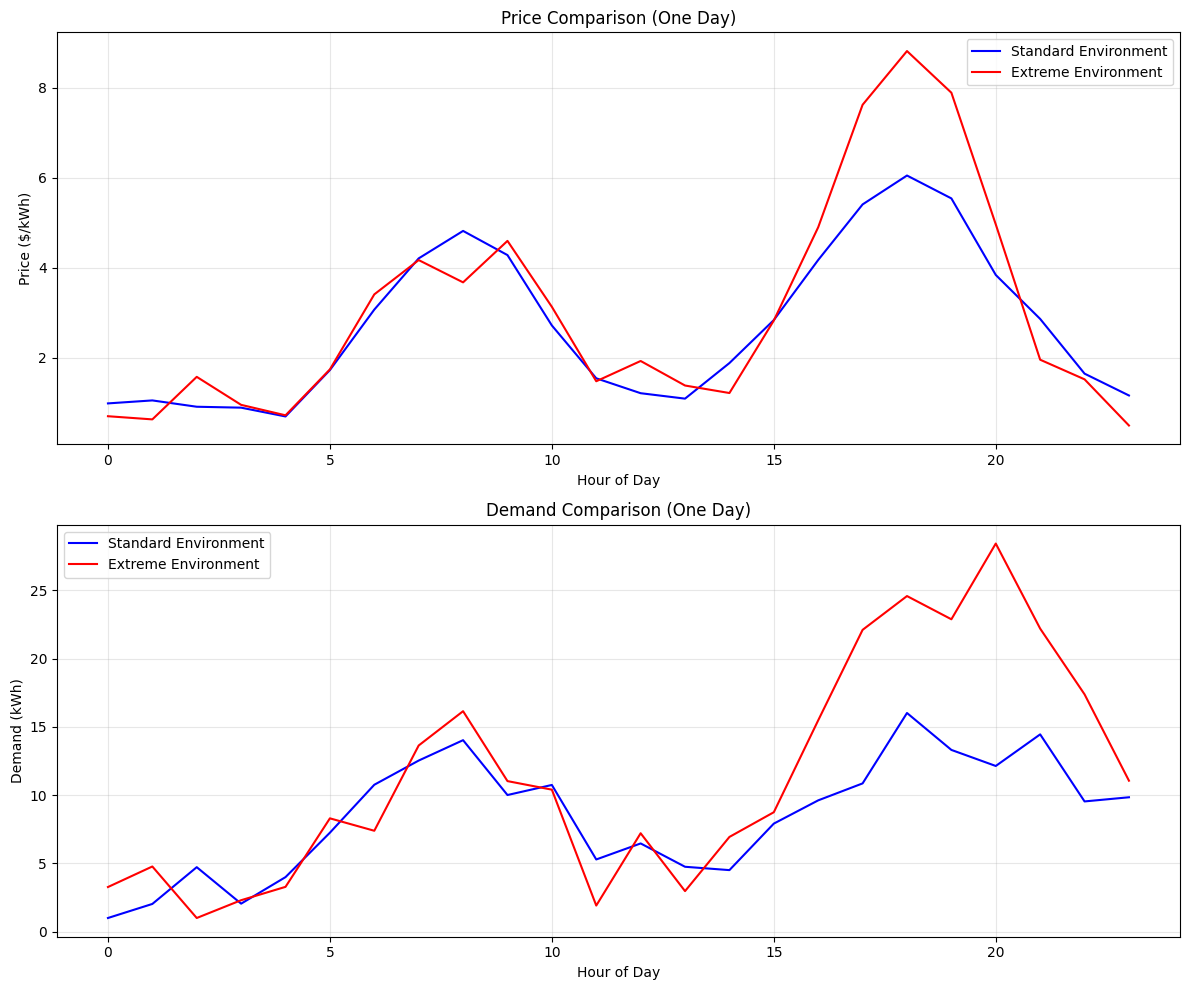

Standard Environment - Price: min=0.70, max=6.05, mean=2.70
Extreme Environment - Price: min=0.50, max=8.82, mean=3.02

Standard Environment - Demand: min=1.00, max=16.02, mean=8.49
Extreme Environment - Demand: min=1.00, max=28.44, mean=11.40


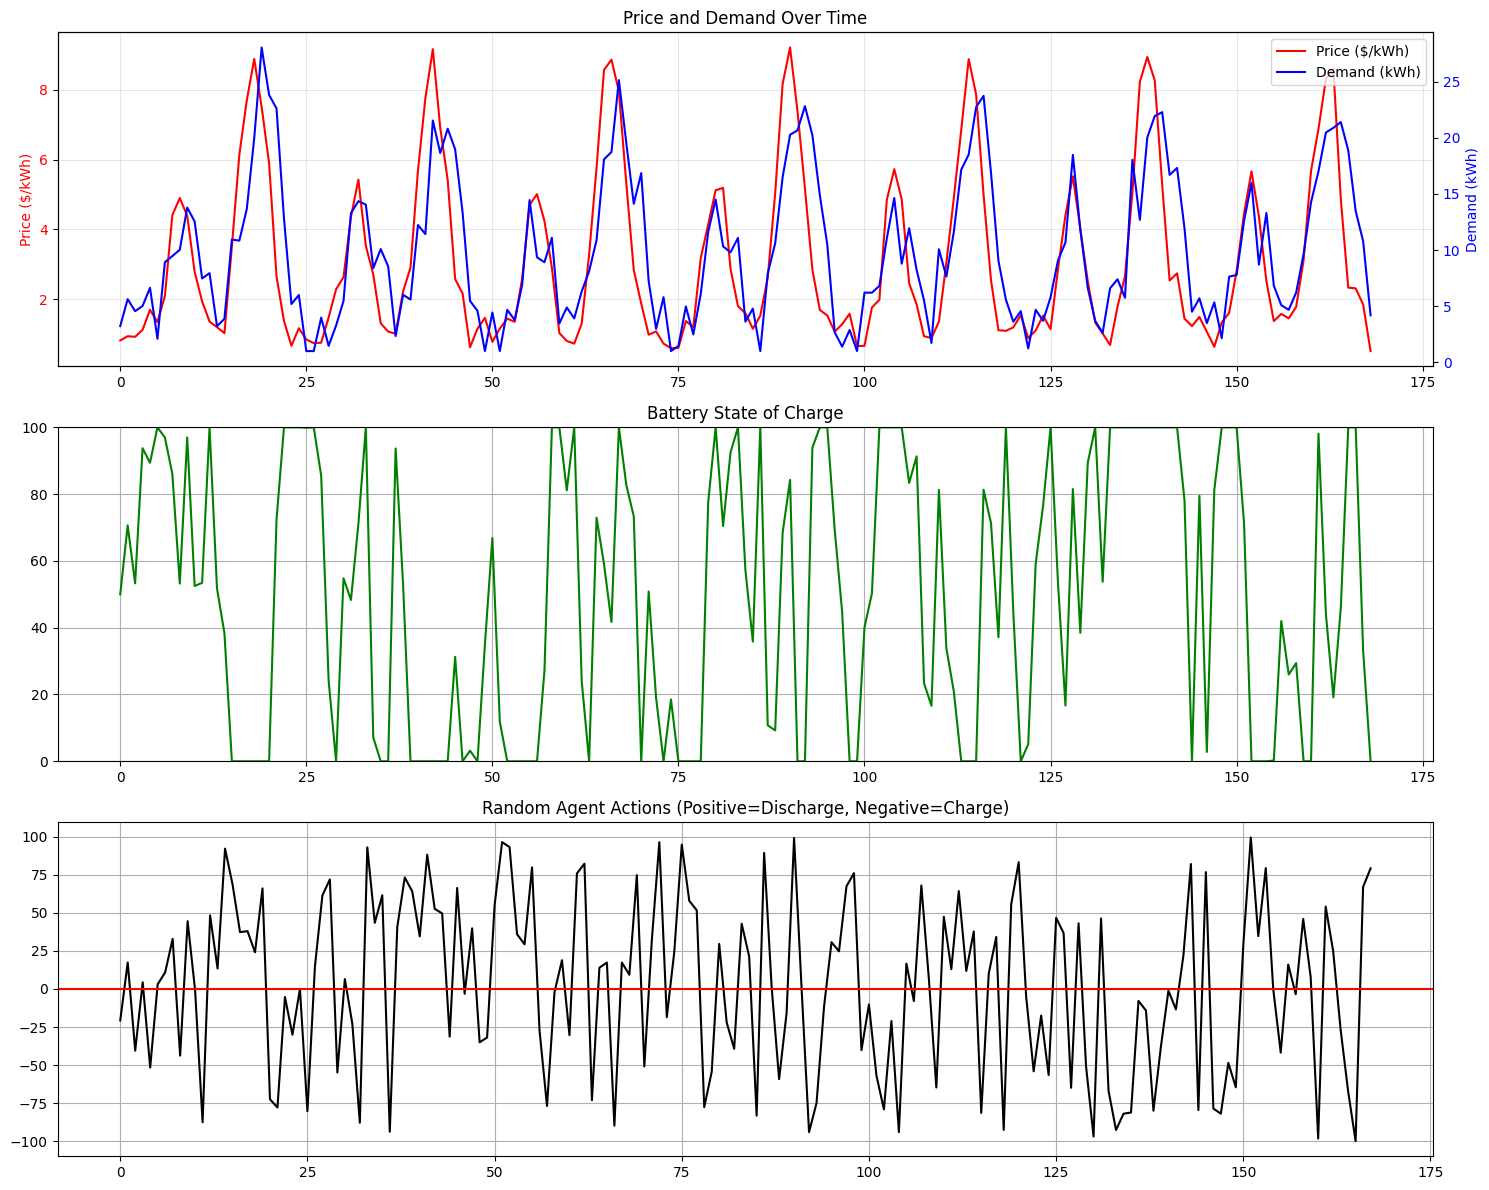

Total reward for random agent: 4053.77


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ExtremeEnvironment(ElectricityMarketEnv):
    """
    An extension of the base ElectricityMarketEnv with more extreme evening price
    and demand peaks to test agent robustness.

    This environment creates more challenging market conditions with:
    1. Higher evening price and demand peaks
    2. More volatility in price and demand
    """

    def __init__(self, battery_capacity=100, max_steps=24*30, render_mode=None):
        """
        Initialize the extreme environment with same parameters as base environment.
        """
        super(ExtremeEnvironment, self).__init__(
            battery_capacity=battery_capacity,
            max_steps=max_steps,
            render_mode=render_mode
        )

    def _get_price(self, step):
        """
        Model electricity price with more extreme evening peak and higher volatility.
        """
        # Convert step to hour of day (0-23)
        hour = step % 24

        # Normal morning peak but intensified evening peak
        morning_peak = 4 * np.exp(-((hour - 8) ** 2) / (2 * (1.5 ** 2)))
        evening_peak = 8 * np.exp(-((hour - 18) ** 2) / (2 * (1.8 ** 2)))  # Higher and sharper evening peak
        base_price = 1 + morning_peak + evening_peak

        # Add more random noise (higher volatility)
        noise = np.random.normal(0, 0.4)  # Double the noise standard deviation
        price = max(0.5, base_price + noise)  # Ensure minimum price of 0.5

        return price

    def _get_demand(self, step):
        """
        Model electricity demand with more extreme evening peak and higher volatility.
        """
        # Convert step to hour of day (0-23)
        hour = step % 24

        # Normal morning peak but intensified evening peak
        morning_peak = 10 * np.exp(-((hour - 8) ** 2) / (2 * (2 ** 2)))
        evening_peak = 20 * np.exp(-((hour - 19) ** 2) / (2 * (2.5 ** 2)))  # Higher evening peak
        base_demand = 3 + morning_peak + evening_peak

        # Add more random noise (higher volatility)
        noise = np.random.normal(0, 2.5)  # Higher noise standard deviation
        demand = max(1, base_demand + noise)  # Ensure minimum demand of 1

        return demand


def compare_environments():
    """
    Create and compare the standard and extreme environments visually.
    """
    # Create environments
    standard_env = ElectricityMarketEnv()
    extreme_env = ExtremeEnvironment()

    # Generate price and demand data for one day
    hours = np.arange(24)

    # Get price and demand data
    std_prices = [standard_env._get_price(h) for h in hours]
    std_demands = [standard_env._get_demand(h) for h in hours]

    ext_prices = [extreme_env._get_price(h) for h in hours]
    ext_demands = [extreme_env._get_demand(h) for h in hours]

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Price comparison
    ax1.plot(hours, std_prices, 'b-', label='Standard Environment')
    ax1.plot(hours, ext_prices, 'r-', label='Extreme Environment')
    ax1.set_title('Price Comparison (One Day)')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Price ($/kWh)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Demand comparison
    ax2.plot(hours, std_demands, 'b-', label='Standard Environment')
    ax2.plot(hours, ext_demands, 'r-', label='Extreme Environment')
    ax2.set_title('Demand Comparison (One Day)')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Demand (kWh)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("Standard Environment - Price: min={:.2f}, max={:.2f}, mean={:.2f}".format(
        min(std_prices), max(std_prices), np.mean(std_prices)))
    print("Extreme Environment - Price: min={:.2f}, max={:.2f}, mean={:.2f}".format(
        min(ext_prices), max(ext_prices), np.mean(ext_prices)))

    print("\nStandard Environment - Demand: min={:.2f}, max={:.2f}, mean={:.2f}".format(
        min(std_demands), max(std_demands), np.mean(std_demands)))
    print("Extreme Environment - Demand: min={:.2f}, max={:.2f}, mean={:.2f}".format(
        min(ext_demands), max(ext_demands), np.mean(ext_demands)))


if __name__ == "__main__":
    # Visualize the difference between environments
    compare_environments()

    # Run a random agent on the extreme environment to see behavior
    extreme_env = ExtremeEnvironment(max_steps=24*7)  # 1 week
    plot_random_agent(extreme_env)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting Training and Evaluation
Environment Parameters:
  Battery Capacity: 100 kWh
  Episode Length: 72 steps (3 days)
  Training Episodes: 25
  Test Episodes: 5

Agent Parameters:
  DQN Action Space: 11 discrete actions
  Batch Size: 64
  Memory Size: 5000

Training DQN Agent...

Training DQN Agent:
[--------------------------------------------------]   0% | Time elapsed: 00:00:00
Pre-filling replay memory with random experiences...
Memory pre-filling complete.
[==================================================] 100% | Episode 25/25 | Reward: 6003.77 | Profit: 6003.77 | Demand Satisfaction: 56.67% | Epsilon: 0.0495 | Episode time: 20.63s | Time: 0:08:20 | ETA: 0:00:00
DQN Training completed!
Total training time: 0:08:20

Training PPO Agent...

Training PPO Agent:
[--------------------------------------------------]   0% | Time elapsed: 00:00:00
[==================================================] 100% | Episode 25/25 | Reward: 58.67 | Profit: 58.67 | Demand Satisfaction: 0.64% | Ep

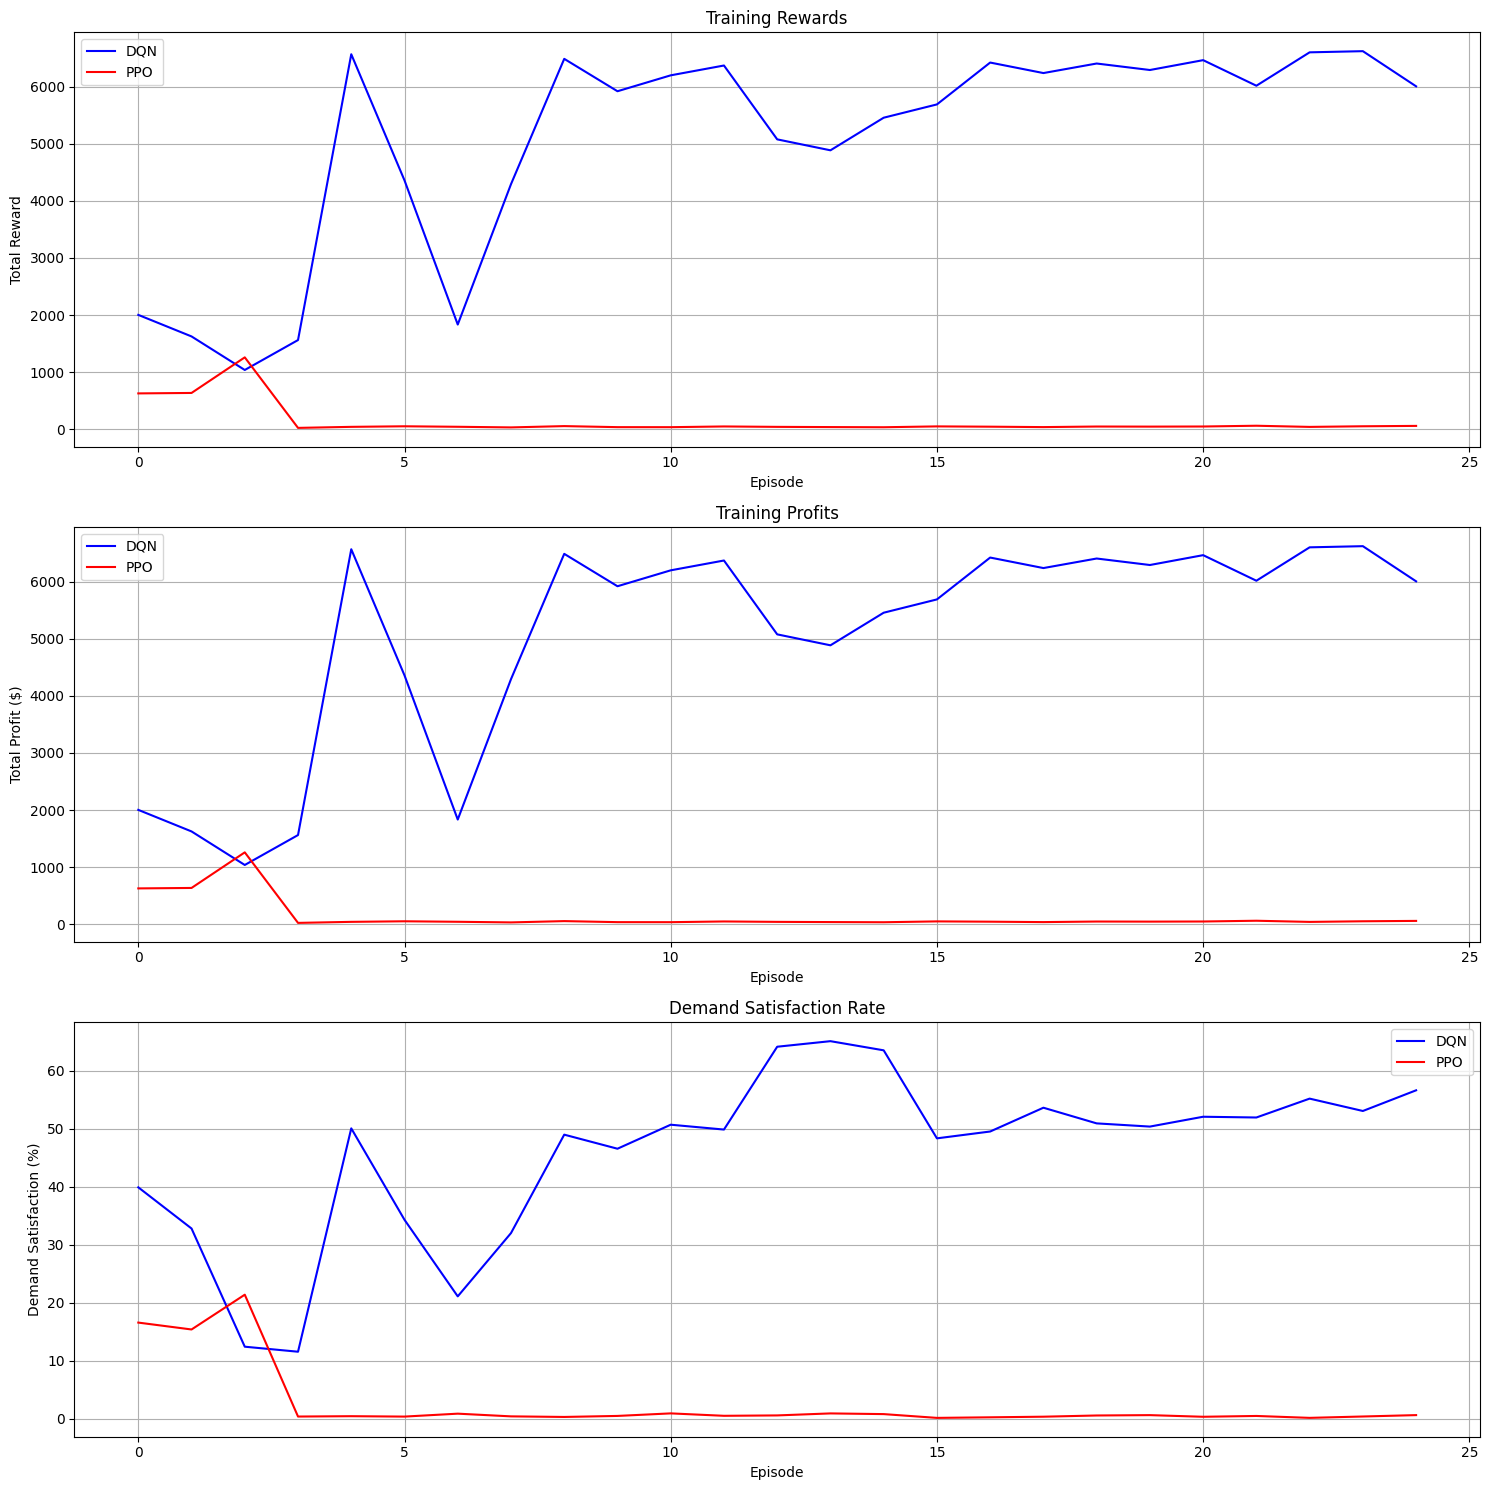


Testing in Standard Environment:

Testing DQN Agent:
[--------------------------------------------------]   0%
[==================================================] 100% | Test Episode 5/5 | Reward: 5546.07 | Profit: 5546.07 | Demand Satisfaction: 51.25% | Price-Action Correlation: -0.57

Test Results for DQN:
Average Reward: 6071.50 ± 299.72
Average Profit: 6071.50 ± 299.72
Average Demand Satisfaction: 54.15%
Average Price-Action Correlation: -0.45

Testing PPO Agent:
[--------------------------------------------------]   0%
[==================================================] 100% | Test Episode 5/5 | Reward: 56.95 | Profit: 56.95 | Demand Satisfaction: 0.97% | Price-Action Correlation: 0.00

Test Results for PPO:
Average Reward: 50.70 ± 5.01
Average Profit: 50.70 ± 5.01
Average Demand Satisfaction: 0.59%
Average Price-Action Correlation: 0.00

Visualizing agent behavior in standard environment:


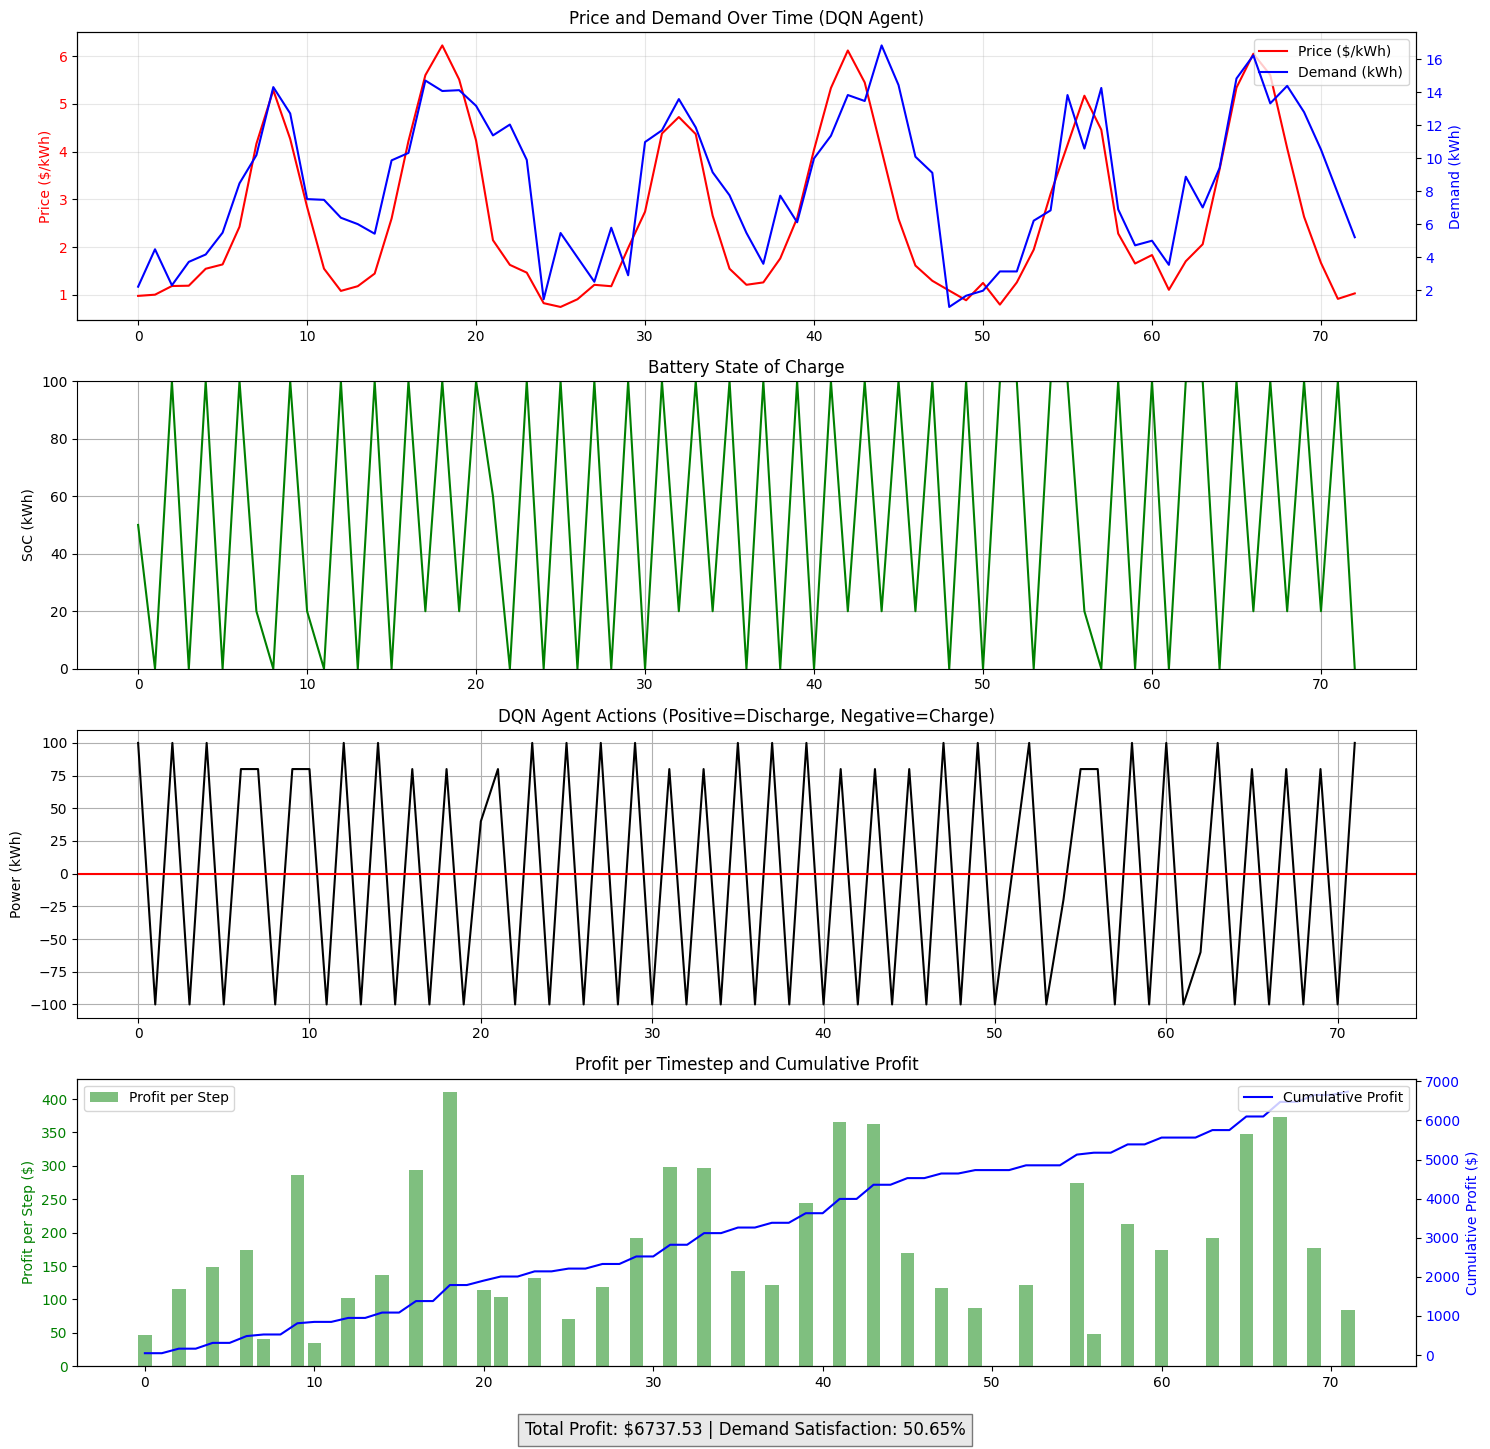

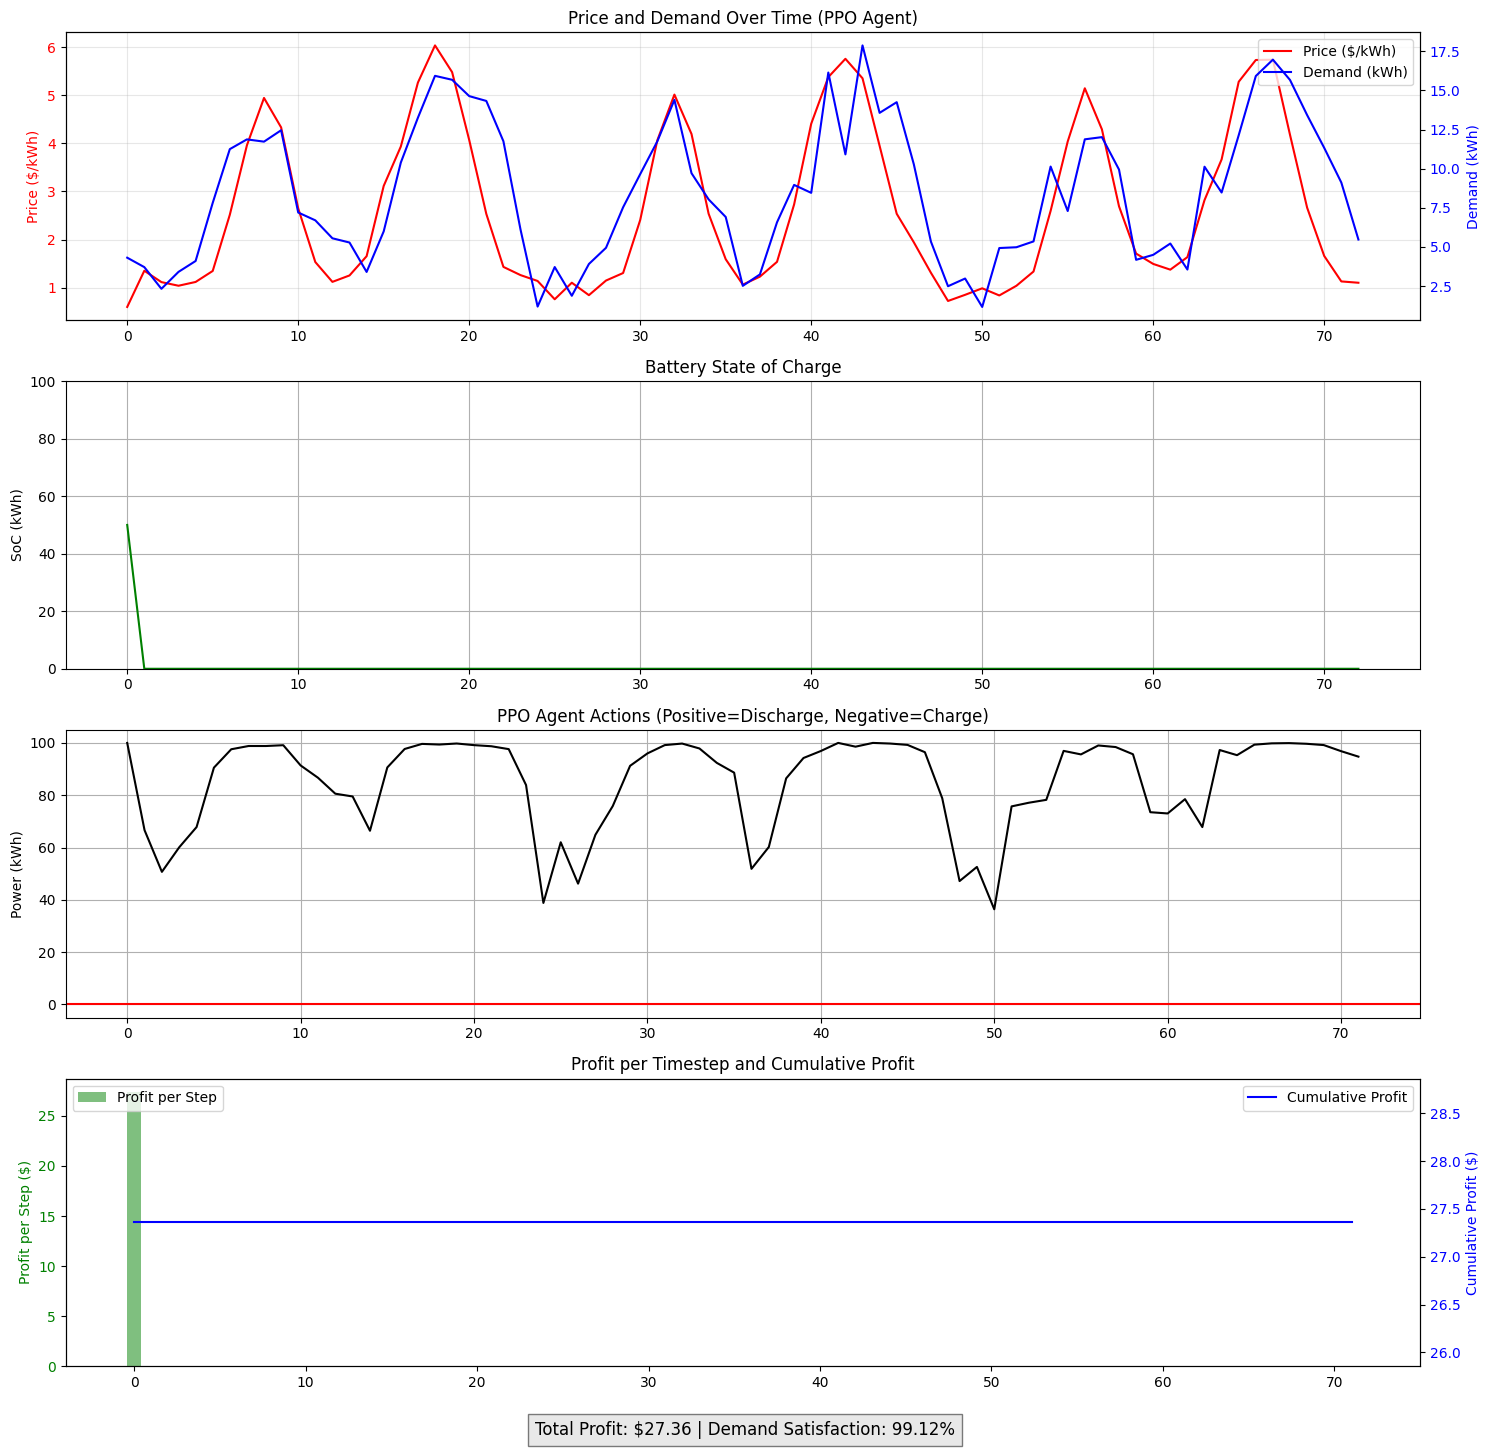


Testing Robustness in Extreme Environment:

Testing DQN Robustness in Extreme Environment:

Testing DQN Agent:
[--------------------------------------------------]   0%
[==================================================] 100% | Test Episode 5/5 | Reward: 6926.68 | Profit: 6926.68 | Demand Satisfaction: 50.26% | Price-Action Correlation: -0.41

Test Results for DQN:
Average Reward: 6903.16 ± 211.28
Average Profit: 6903.16 ± 211.28
Average Demand Satisfaction: 51.36%
Average Price-Action Correlation: -0.32

Testing PPO Robustness in Extreme Environment:

Testing PPO Agent:
[--------------------------------------------------]   0%
[==================================================] 100% | Test Episode 5/5 | Reward: 33.55 | Profit: 33.55 | Demand Satisfaction: 0.92% | Price-Action Correlation: 0.00

Test Results for PPO:
Average Reward: 46.93 ± 21.19
Average Profit: 46.93 ± 21.19
Average Demand Satisfaction: 0.57%
Average Price-Action Correlation: 0.00

Visualizing agent behavior in ext

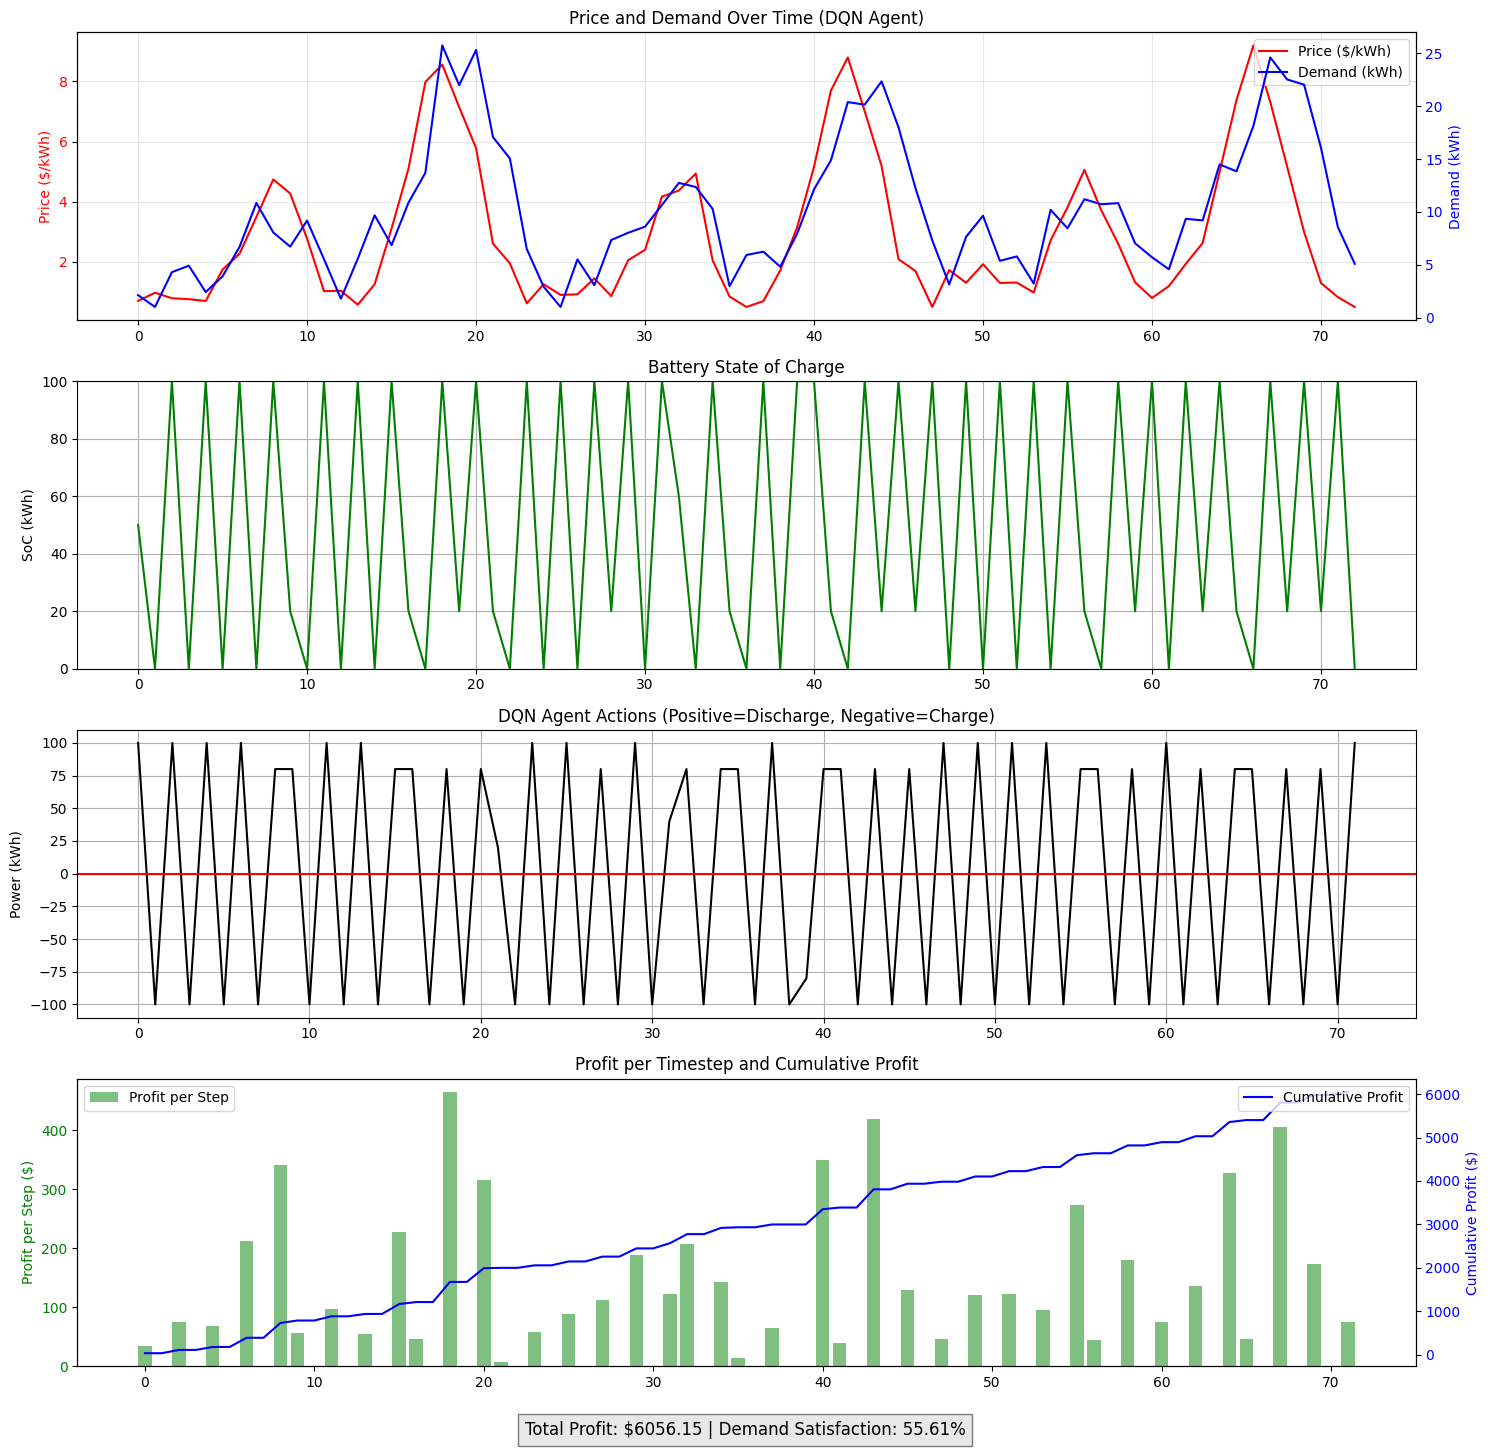

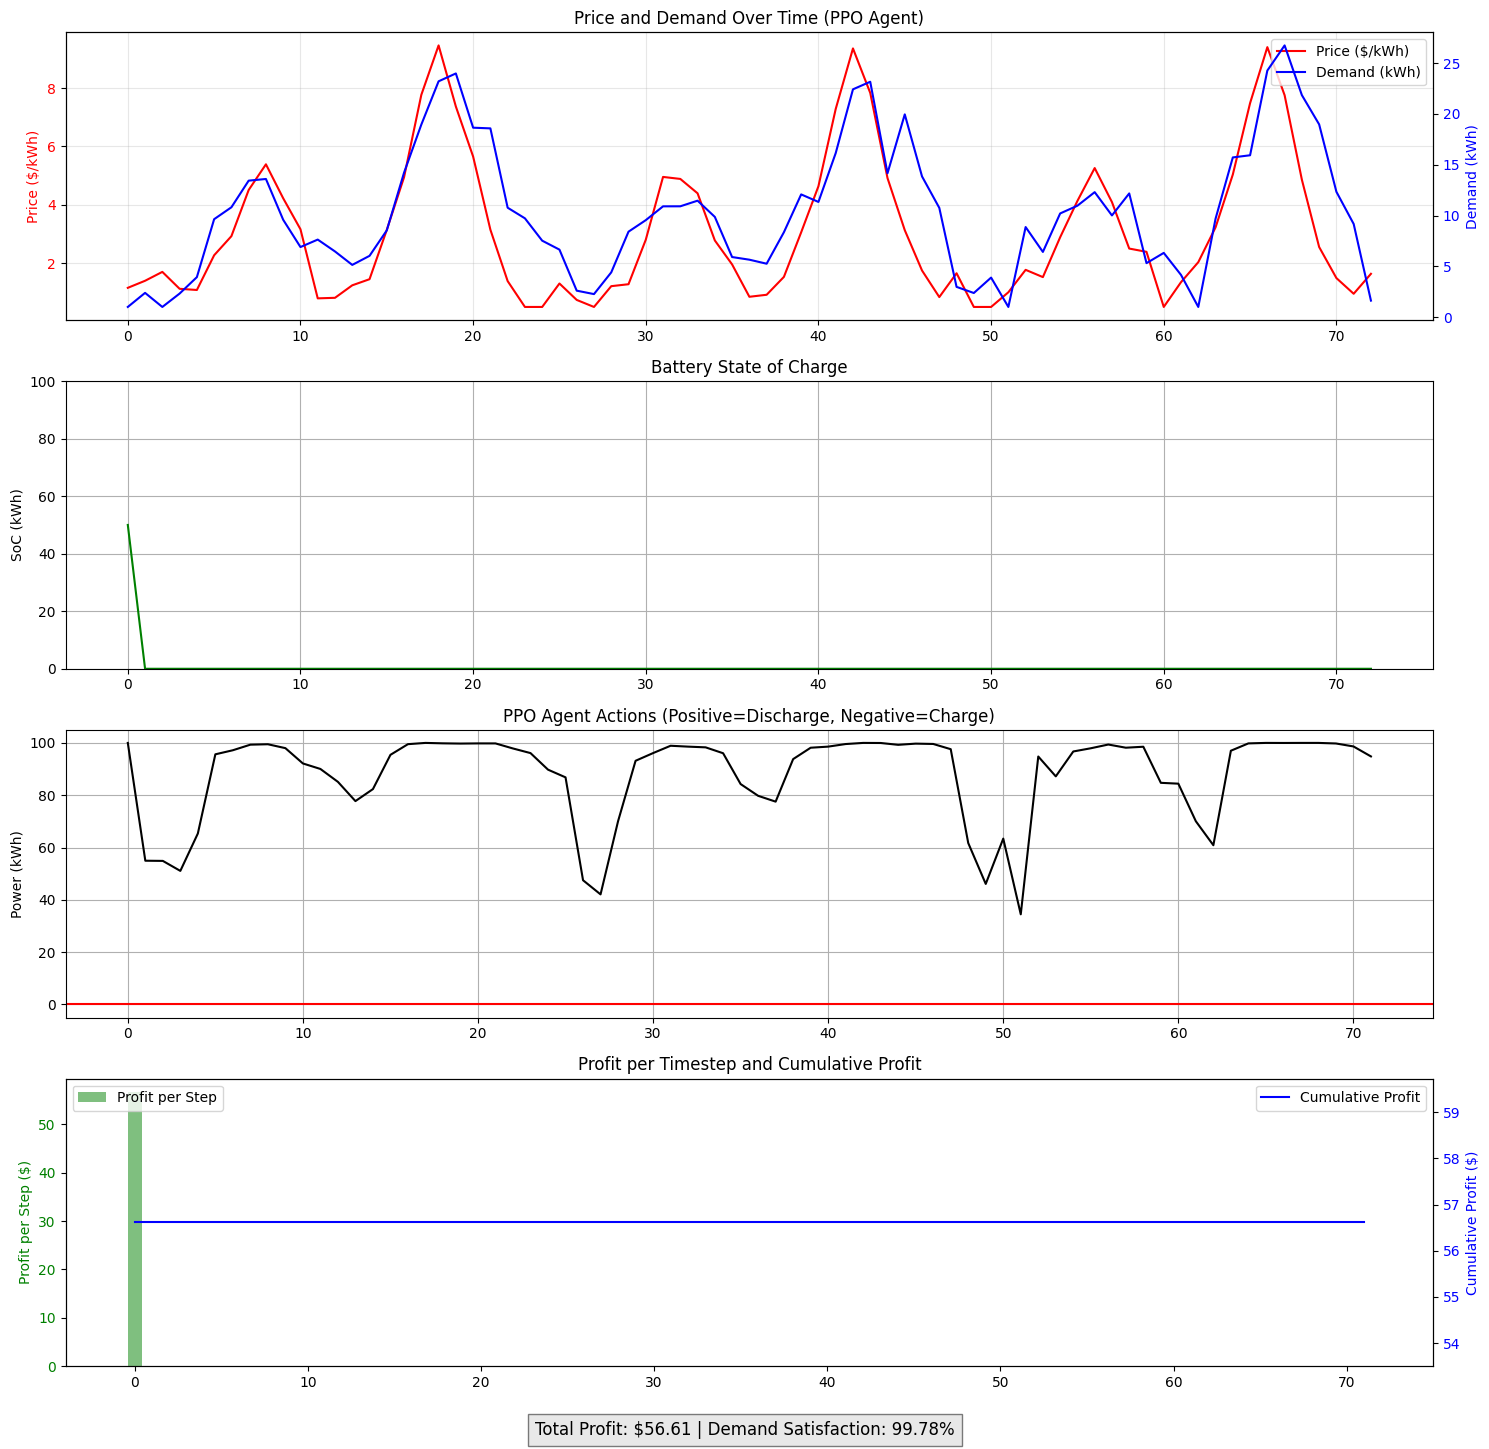

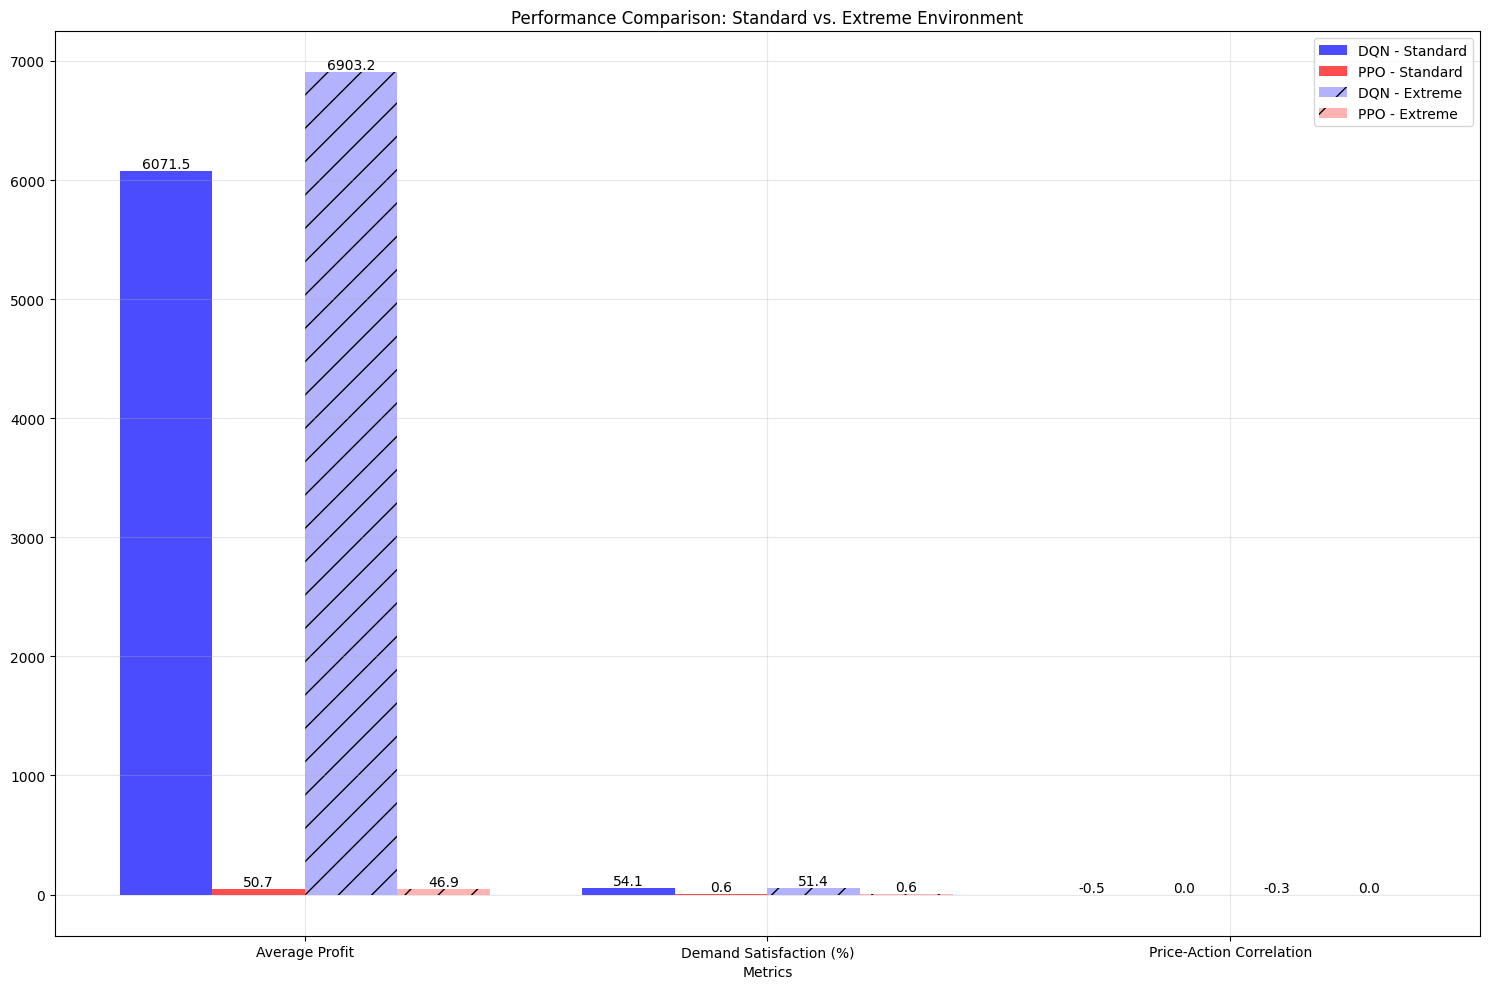

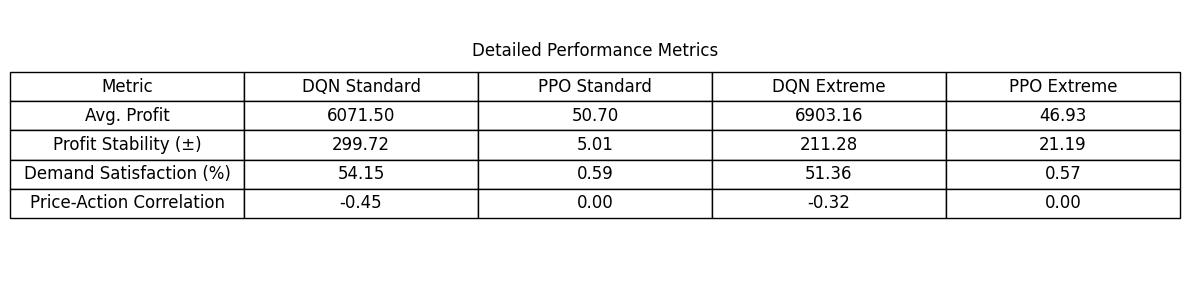


Training and Evaluation Summary:
Total time: 0:13:53

Standard Environment Results:
  DQN Profit: 6071.50 ± 299.72
  PPO Profit: 50.70 ± 5.01
  DQN Demand Satisfaction: 54.15%
  PPO Demand Satisfaction: 0.59%

Extreme Environment Results:
  DQN Profit: 6903.16 ± 211.28
  PPO Profit: 46.93 ± 21.19
  DQN Demand Satisfaction: 51.36%
  PPO Demand Satisfaction: 0.57%

Robustness Analysis:
  DQN Profit in Extreme vs Standard: 113.7%
  PPO Profit in Extreme vs Standard: 92.6%

DQN agent showed better robustness to extreme market conditions.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from datetime import timedelta


# Create directories for saving models and figures
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Training parameters
EPISODES = 25  # Number of episodes to train
PRINT_EVERY = 1  # Update progress every episode
SAVE_EVERY = 5   # Save model every 5 episodes
TEST_EPISODES = 5  # Number of test episodes
STEPS_PER_EPISODE = 24 * 3  # 3 days per episode
BATTERY_CAPACITY = 100

# Discretization for DQN
ACTION_SIZE = 11  # 11 discrete actions

# Hyperparameters
BATCH_SIZE = 64
MEMORY_SIZE = 5000

def ensure_scalar(value):
    """Ensure a value is a scalar (for consistent reward and action handling)"""
    if isinstance(value, np.ndarray):
        if value.size == 1:
            return value.item()
        else:
            return float(value[0])
    return float(value)

def train_dqn(env, agent, episodes=EPISODES):
    """
    Train a DQN agent.

    Args:
        env: The environment
        agent: The DQN agent
        episodes: Number of episodes to train

    Returns:
        dict: Performance metrics including rewards, profits, and more
    """
    rewards = []
    profits = []
    demand_satisfaction_rates = []
    start_time = time.time()

    print("\nTraining DQN Agent:")
    print("[" + "-" * 50 + "]   0% | Time elapsed: 00:00:00")

    # Pre-fill memory with some random experiences
    print("Pre-filling replay memory with random experiences...")
    state, _ = env.reset()
    for _ in range(min(BATCH_SIZE * 2, MEMORY_SIZE // 10)):
        action = np.random.uniform(low=-BATTERY_CAPACITY, high=BATTERY_CAPACITY)
        action_index = np.random.randint(0, ACTION_SIZE)
        next_state, reward, terminated, truncated, _ = env.step(np.array([action]))
        agent.remember(state, action_index, reward, next_state, terminated or truncated)
        if terminated or truncated:
            state, _ = env.reset()
        else:
            state = next_state
    print("Memory pre-filling complete.")

    for episode in range(1, episodes + 1):
        episode_start_time = time.time()
        state, _ = env.reset()
        total_reward = 0
        total_demand = 0
        demand_met = 0

        for step in range(STEPS_PER_EPISODE):
            # Choose action
            action, action_index = agent.act(state)

            # Take step
            next_state, reward, terminated, truncated, info = env.step(np.array([action]))

            # Ensure reward is a scalar
            reward = ensure_scalar(reward)

            # Store in replay memory
            agent.remember(state, action_index, reward, next_state, terminated or truncated)

            # Track demand satisfaction
            total_demand += info['demand']
            if info['actual_action'] > 0:  # If discharging
                demand_met += min(info['actual_action'], info['demand'])

            # Learn from experience (only if we have enough samples)
            if len(agent.memory) >= BATCH_SIZE:
                agent.replay()

            # Update state and reward
            state = next_state
            total_reward += reward

            if terminated or truncated:
                break

        # Update target network periodically
        if episode % 5 == 0:
            agent.update_target_model()

        # Calculate demand satisfaction rate
        satisfaction_rate = (demand_met / total_demand * 100) if total_demand > 0 else 0

        # Record metrics
        rewards.append(total_reward)
        total_profit = sum(env.profit_history)
        profits.append(total_profit)
        demand_satisfaction_rates.append(satisfaction_rate)

        # Print progress
        progress = episode / episodes
        progress_bar = "[" + "=" * int(50 * progress) + "-" * (50 - int(50 * progress)) + "]"
        elapsed_time = time.time() - start_time
        episode_time = time.time() - episode_start_time
        eta = (elapsed_time / episode) * (episodes - episode) if episode > 0 else 0

        print(f"\r{progress_bar} {progress*100:3.0f}% | Episode {episode}/{episodes} | " +
              f"Reward: {total_reward:.2f} | Profit: {total_profit:.2f} | " +
              f"Demand Satisfaction: {satisfaction_rate:.2f}% | Epsilon: {agent.epsilon:.4f} | " +
              f"Episode time: {episode_time:.2f}s | " +
              f"Time: {str(timedelta(seconds=int(elapsed_time)))} | " +
              f"ETA: {str(timedelta(seconds=int(eta)))}", end="")

        # Save model
        if episode % SAVE_EVERY == 0:
            agent.save(f"models/dqn_model_{episode}.h5")

    print("\nDQN Training completed!")
    total_time = time.time() - start_time
    print(f"Total training time: {str(timedelta(seconds=int(total_time)))}")

    return {
        "rewards": rewards,
        "profits": profits,
        "demand_satisfaction_rates": demand_satisfaction_rates,
        "training_time": total_time
    }

def train_ppo(env, agent, episodes=EPISODES):
    """
    Train a PPO agent.

    Args:
        env: The environment
        agent: The PPO agent
        episodes: Number of episodes to train

    Returns:
        dict: Performance metrics including rewards, profits, and more
    """
    rewards = []
    profits = []
    demand_satisfaction_rates = []
    start_time = time.time()

    print("\nTraining PPO Agent:")
    print("[" + "-" * 50 + "]   0% | Time elapsed: 00:00:00")

    # Make decisions randomly during initial episodes to collect diverse experiences
    initial_exploration_episodes = 3

    for episode in range(1, episodes + 1):
        episode_start_time = time.time()
        state, _ = env.reset()
        total_reward = 0
        total_demand = 0
        demand_met = 0

        # Initialize episode-specific variables
        episode_states = []
        episode_actions = []
        episode_rewards = []
        episode_next_states = []
        episode_dones = []
        episode_log_probs = []

        for step in range(STEPS_PER_EPISODE):
            # Choose action
            # For initial episodes, add random noise to encourage exploration
            if episode <= initial_exploration_episodes:
                # Mix random exploration with policy-based actions
                if np.random.random() < 0.5:  # 50% chance of random action
                    action = np.random.uniform(-BATTERY_CAPACITY / 2, BATTERY_CAPACITY / 2)
                    log_prob = 0  # Placeholder for random actions
                else:
                    action, log_prob = agent.act(state)
            else:
                action, log_prob = agent.act(state)

            # Ensure action is in the correct format for the environment
            if isinstance(action, np.ndarray) and action.size == 1:
                action = action.item()

            # Take step with properly formatted action
            next_state, reward, terminated, truncated, info = env.step(np.array([action]))

            # Ensure reward is a scalar
            reward = ensure_scalar(reward)

            # Store experience for this episode
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            episode_next_states.append(next_state)
            episode_dones.append(terminated or truncated)
            episode_log_probs.append(log_prob)

            # Track demand satisfaction
            total_demand += info['demand']
            if info['actual_action'] > 0:  # If discharging
                demand_met += min(info['actual_action'], info['demand'])

            # Update state and reward
            state = next_state
            total_reward += reward

            if terminated or truncated:
                break

        # Add episode experiences to agent memory
        for i in range(len(episode_states)):
            agent.remember(
                episode_states[i],
                episode_actions[i],
                episode_rewards[i],
                episode_next_states[i],
                episode_dones[i],
                episode_log_probs[i]
            )

        # Update policy after episode (only if we have enough samples)
        if len(agent.states) >= BATCH_SIZE:
            agent.update()

        # Calculate demand satisfaction rate
        satisfaction_rate = (demand_met / total_demand * 100) if total_demand > 0 else 0

        # Record metrics
        rewards.append(total_reward)
        total_profit = sum(env.profit_history)
        profits.append(total_profit)
        demand_satisfaction_rates.append(satisfaction_rate)

        # Print progress
        progress = episode / episodes
        progress_bar = "[" + "=" * int(50 * progress) + "-" * (50 - int(50 * progress)) + "]"
        elapsed_time = time.time() - start_time
        episode_time = time.time() - episode_start_time
        eta = (elapsed_time / episode) * (episodes - episode) if episode > 0 else 0

        print(f"\r{progress_bar} {progress*100:3.0f}% | Episode {episode}/{episodes} | " +
              f"Reward: {total_reward:.2f} | Profit: {total_profit:.2f} | " +
              f"Demand Satisfaction: {satisfaction_rate:.2f}% | " +
              f"Episode time: {episode_time:.2f}s | " +
              f"Time: {str(timedelta(seconds=int(elapsed_time)))} | " +
              f"ETA: {str(timedelta(seconds=int(eta)))}", end="")

        # Save model
        if episode % SAVE_EVERY == 0:
            agent.save(f"models/ppo_actor_{episode}.h5", f"models/ppo_critic_{episode}.h5")

    print("\nPPO Training completed!")
    total_time = time.time() - start_time
    print(f"Total training time: {str(timedelta(seconds=int(total_time)))}")

    return {
        "rewards": rewards,
        "profits": profits,
        "demand_satisfaction_rates": demand_satisfaction_rates,
        "training_time": total_time
    }

def test_agent(env, agent, agent_type, episodes=TEST_EPISODES):
    """
    Test an agent on the environment.

    Args:
        env: The environment
        agent: The agent to test
        agent_type: String indicating agent type ("DQN" or "PPO")
        episodes: Number of episodes to test

    Returns:
        dict: Performance metrics including rewards, profits, demand satisfaction, etc.
    """
    total_rewards = []
    total_profits = []
    demand_satisfaction_rates = []
    price_correlations = []  # Correlation between price and action

    print(f"\nTesting {agent_type} Agent:")
    print("[" + "-" * 50 + "]   0%")

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        episode_reward = 0
        total_demand = 0
        demand_met = 0

        # For price-action correlation
        prices = []
        actions = []

        for step in range(STEPS_PER_EPISODE):
            # Choose action based on agent type
            if agent_type == "DQN":
                action, _ = agent.act(state)
            else:  # PPO
                action, _ = agent.act(state)
                # Ensure action is a scalar
                if isinstance(action, np.ndarray) and action.size == 1:
                    action = action.item()

            # Track current price
            prices.append(float(state[2]))  # Price is the third state component

            # Take step with properly formatted action
            next_state, reward, terminated, truncated, info = env.step(np.array([action]))

            # Ensure reward is a scalar
            reward = ensure_scalar(reward)

            # Track action taken (actual action after environment processing)
            actual_action = ensure_scalar(info['actual_action'])
            actions.append(actual_action)

            # Track demand satisfaction
            total_demand += info['demand']
            if actual_action > 0:  # If discharging
                demand_met += min(actual_action, info['demand'])

            # Update state and reward
            state = next_state
            episode_reward += reward

            if terminated or truncated:
                break

        # Calculate demand satisfaction rate
        demand_satisfaction = (demand_met / total_demand * 100) if total_demand > 0 else 0

        # Calculate correlation between price and discharge actions
        try:
            # Filter to only include discharge actions (positive values)
            discharge_indices = [i for i, a in enumerate(actions) if a > 0]

            if len(discharge_indices) > 1:
                discharge_prices = np.array([prices[i] for i in discharge_indices])
                discharge_actions = np.array([actions[i] for i in discharge_indices])

                # Calculate correlation
                corr_matrix = np.corrcoef(discharge_prices, discharge_actions)
                if corr_matrix.shape == (2, 2):  # Ensure we have a valid correlation matrix
                    price_action_corr = float(corr_matrix[0, 1])
                    if np.isnan(price_action_corr):
                        price_action_corr = 0.0
                else:
                    price_action_corr = 0.0
            else:
                price_action_corr = 0.0  # Not enough discharge actions
        except Exception as e:
            print(f"Error calculating correlation: {e}")
            price_action_corr = 0.0

        # Collect episode metrics
        total_rewards.append(episode_reward)
        total_profits.append(float(sum(env.profit_history)))
        demand_satisfaction_rates.append(demand_satisfaction)
        price_correlations.append(price_action_corr)

        # Print progress
        progress = episode / episodes
        progress_bar = "[" + "=" * int(50 * progress) + "-" * (50 - int(50 * progress)) + "]"
        print(f"\r{progress_bar} {progress*100:3.0f}% | Test Episode {episode}/{episodes} | " +
              f"Reward: {episode_reward:.2f} | Profit: {sum(env.profit_history):.2f} | " +
              f"Demand Satisfaction: {demand_satisfaction:.2f}% | " +
              f"Price-Action Correlation: {price_action_corr:.2f}", end="")

    print("\n")

    # Calculate average metrics
    avg_reward = float(np.mean(total_rewards))
    avg_profit = float(np.mean(total_profits))
    avg_demand_satisfaction = float(np.mean(demand_satisfaction_rates))
    avg_price_correlation = float(np.mean(price_correlations))

    # Calculate standard deviations (stability metrics)
    std_reward = float(np.std(total_rewards))
    std_profit = float(np.std(total_profits))

    print(f"Test Results for {agent_type}:")
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Average Profit: {avg_profit:.2f} ± {std_profit:.2f}")
    print(f"Average Demand Satisfaction: {avg_demand_satisfaction:.2f}%")
    print(f"Average Price-Action Correlation: {avg_price_correlation:.2f}")

    return {
        "avg_reward": avg_reward,
        "avg_profit": avg_profit,
        "avg_demand_satisfaction": avg_demand_satisfaction,
        "avg_price_correlation": avg_price_correlation,
        "std_reward": std_reward,
        "std_profit": std_profit,
        "rewards": total_rewards,
        "profits": total_profits,
        "demand_satisfaction_rates": demand_satisfaction_rates,
        "price_correlations": price_correlations
    }

def test_robustness(env, agent, agent_type, episodes=TEST_EPISODES):
    """
    Test an agent on the extreme environment to assess robustness.

    Args:
        env: The extreme environment
        agent: The agent to test
        agent_type: String indicating agent type ("DQN" or "PPO")
        episodes: Number of episodes to test

    Returns:
        dict: Performance metrics in extreme environment
    """
    print(f"\nTesting {agent_type} Robustness in Extreme Environment:")
    return test_agent(env, agent, agent_type, episodes)

def visualize_agent_behavior(env, agent, agent_type, filename_suffix=""):
    """
    Visualize agent behavior in the environment.

    Args:
        env: The environment
        agent: The agent
        agent_type: String indicating agent type ("DQN" or "PPO")
        filename_suffix: Optional suffix for the saved file name
    """
    state, _ = env.reset()

    # Run one episode
    for step in range(STEPS_PER_EPISODE):
        # Choose action based on agent type
        if agent_type == "DQN":
            action, _ = agent.act(state)
        else:  # PPO
            action, _ = agent.act(state)
            # Ensure action is a scalar
            if isinstance(action, np.ndarray) and action.size == 1:
                action = action.item()

        # Take step with properly formatted action
        state, reward, terminated, truncated, info = env.step(np.array([action]))

        if terminated or truncated:
            break

    # Calculate metrics
    total_profit = float(sum(env.profit_history))

    # Calculate demand satisfaction
    total_demand = sum(env.demand_history)
    demand_met = 0
    for i, action in enumerate(env.action_history):
        if action > 0:  # If discharging
            demand = env.demand_history[i] if i < len(env.demand_history) else 0
            demand_met += min(action, demand)

    demand_satisfaction = (demand_met / total_demand * 100) if total_demand > 0 else 0

    # Plot results
    plt.figure(figsize=(15, 15))

    # Plot price and demand with dual y-axes
    ax1 = plt.subplot(4, 1, 1)
    plt.title(f'Price and Demand Over Time ({agent_type} Agent)')

    # Price on left y-axis
    line1, = ax1.plot(env.price_history, 'r-', label='Price ($/kWh)')
    ax1.set_ylabel('Price ($/kWh)', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.grid(True, alpha=0.3)

    # Demand on right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(env.demand_history, 'b-', label='Demand (kWh)')
    ax2.set_ylabel('Demand (kWh)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Combined legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    # Plot battery SoC
    plt.subplot(4, 1, 2)
    plt.title('Battery State of Charge')
    plt.plot(env.soc_history, 'g-')
    plt.ylim(0, env.battery_capacity)
    plt.ylabel('SoC (kWh)')
    plt.grid(True)

    # Plot actions
    plt.subplot(4, 1, 3)
    plt.title(f'{agent_type} Agent Actions (Positive=Discharge, Negative=Charge)')
    plt.plot(env.action_history, 'k-')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.ylabel('Power (kWh)')
    plt.grid(True)

    # Plot profit and cumulative profit
    plt.subplot(4, 1, 4)
    plt.title('Profit per Timestep and Cumulative Profit')
    plt.bar(range(len(env.profit_history)), env.profit_history, color='g', alpha=0.5, label='Profit per Step')

    # Cumulative profit on right y-axis
    ax3 = plt.gca()
    ax4 = ax3.twinx()
    cumulative_profit = np.cumsum(env.profit_history)
    ax4.plot(cumulative_profit, 'b-', label='Cumulative Profit')
    ax4.set_ylabel('Cumulative Profit ($)', color='b')
    ax4.tick_params(axis='y', labelcolor='b')

    # Combined legend
    ax3.set_ylabel('Profit per Step ($)', color='g')
    ax3.tick_params(axis='y', labelcolor='g')
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper right')

    # Add a text box with metrics
    plt.figtext(0.5, 0.01,
                f'Total Profit: ${total_profit:.2f} | Demand Satisfaction: {demand_satisfaction:.2f}%',
                ha='center', fontsize=12,
                bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for text
    filename = f'figures/{agent_type.lower()}_agent_behavior'
    if filename_suffix:
        filename += f'_{filename_suffix}'
    plt.savefig(f'{filename}.png')
    plt.show()

def compare_learning_curves(dqn_metrics, ppo_metrics):
    """
    Plot comparative learning curves for both agents.

    Args:
        dqn_metrics: Dictionary with DQN training metrics
        ppo_metrics: Dictionary with PPO training metrics
    """
    plt.figure(figsize=(15, 15))

    # Plot rewards
    plt.subplot(3, 1, 1)
    plt.plot(dqn_metrics['rewards'], 'b-', label='DQN')
    plt.plot(ppo_metrics['rewards'], 'r-', label='PPO')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)

    # Plot profits
    plt.subplot(3, 1, 2)
    plt.plot(dqn_metrics['profits'], 'b-', label='DQN')
    plt.plot(ppo_metrics['profits'], 'r-', label='PPO')
    plt.title('Training Profits')
    plt.xlabel('Episode')
    plt.ylabel('Total Profit ($)')
    plt.legend()
    plt.grid(True)

    # Plot demand satisfaction rate
    plt.subplot(3, 1, 3)
    plt.plot(dqn_metrics['demand_satisfaction_rates'], 'b-', label='DQN')
    plt.plot(ppo_metrics['demand_satisfaction_rates'], 'r-', label='PPO')
    plt.title('Demand Satisfaction Rate')
    plt.xlabel('Episode')
    plt.ylabel('Demand Satisfaction (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('figures/learning_curves_comparison.png')
    plt.show()

def visualize_test_results(dqn_std_results, ppo_std_results, dqn_extreme_results, ppo_extreme_results):
    """
    Visualize test results for both agents in standard and extreme environments.

    Args:
        dqn_std_results: DQN results in standard environment
        ppo_std_results: PPO results in standard environment
        dqn_extreme_results: DQN results in extreme environment
        ppo_extreme_results: PPO results in extreme environment
    """
    # Create bar chart comparison
    plt.figure(figsize=(15, 10))

    # Labels for the bar groups
    labels = ['Average Profit', 'Demand Satisfaction (%)', 'Price-Action Correlation']

    # Data for each metric
    dqn_std_data = [dqn_std_results['avg_profit'], dqn_std_results['avg_demand_satisfaction'], dqn_std_results['avg_price_correlation']]
    ppo_std_data = [ppo_std_results['avg_profit'], ppo_std_results['avg_demand_satisfaction'], ppo_std_results['avg_price_correlation']]
    dqn_ext_data = [dqn_extreme_results['avg_profit'], dqn_extreme_results['avg_demand_satisfaction'], dqn_extreme_results['avg_price_correlation']]
    ppo_ext_data = [ppo_extreme_results['avg_profit'], ppo_extreme_results['avg_demand_satisfaction'], ppo_extreme_results['avg_price_correlation']]

    # Width of each bar
    bar_width = 0.2

    # Position of bars on x-axis
    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Create bars
    plt.bar(r1, dqn_std_data, width=bar_width, label='DQN - Standard', color='blue', alpha=0.7)
    plt.bar(r2, ppo_std_data, width=bar_width, label='PPO - Standard', color='red', alpha=0.7)
    plt.bar(r3, dqn_ext_data, width=bar_width, label='DQN - Extreme', color='blue', alpha=0.3, hatch='/')
    plt.bar(r4, ppo_ext_data, width=bar_width, label='PPO - Extreme', color='red', alpha=0.3, hatch='/')

    # Add labels and title
    plt.xlabel('Metrics')
    plt.xticks([r + bar_width*1.5 for r in range(len(labels))], labels)
    plt.title('Performance Comparison: Standard vs. Extreme Environment')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value labels on top of bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{height:.1f}', ha='center', va='bottom')

    # Get all the bar containers and add labels
    for bars in plt.gca().containers:
        add_labels(bars)

    plt.tight_layout()
    plt.savefig('figures/test_results_comparison.png')
    plt.show()

    # Create a table with detailed metrics
    plt.figure(figsize=(12, 3))
    plt.axis('off')

    table_data = [
        ['Metric', 'DQN Standard', 'PPO Standard', 'DQN Extreme', 'PPO Extreme'],
        ['Avg. Profit', f"{dqn_std_results['avg_profit']:.2f}", f"{ppo_std_results['avg_profit']:.2f}",
         f"{dqn_extreme_results['avg_profit']:.2f}", f"{ppo_extreme_results['avg_profit']:.2f}"],
        ['Profit Stability (±)', f"{dqn_std_results['std_profit']:.2f}", f"{ppo_std_results['std_profit']:.2f}",
         f"{dqn_extreme_results['std_profit']:.2f}", f"{ppo_extreme_results['std_profit']:.2f}"],
        ['Demand Satisfaction (%)', f"{dqn_std_results['avg_demand_satisfaction']:.2f}", f"{ppo_std_results['avg_demand_satisfaction']:.2f}",
         f"{dqn_extreme_results['avg_demand_satisfaction']:.2f}", f"{ppo_extreme_results['avg_demand_satisfaction']:.2f}"],
        ['Price-Action Correlation', f"{dqn_std_results['avg_price_correlation']:.2f}", f"{ppo_std_results['avg_price_correlation']:.2f}",
         f"{dqn_extreme_results['avg_price_correlation']:.2f}", f"{ppo_extreme_results['avg_price_correlation']:.2f}"]
    ]

    table = plt.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.2, 0.2, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    # Add title
    plt.title('Detailed Performance Metrics', y=0.8)

    plt.tight_layout()
    plt.savefig('figures/metrics_table.png')
    plt.show()

def main():
    """
    Main function to run training and evaluation.
    """
    # Create directory for saving models and figures
    os.makedirs('models', exist_ok=True)
    os.makedirs('figures', exist_ok=True)

    # Create environments
    std_env = ElectricityMarketEnv(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)
    extreme_env = ExtremeEnvironment(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)

    # Get state dimensions
    state_size = std_env.observation_space.shape[0]

    # Create agents
    dqn_agent = DQNAgent(
        state_size=state_size,
        action_size=ACTION_SIZE,
        battery_capacity=BATTERY_CAPACITY,
        batch_size=BATCH_SIZE,
        memory_size=MEMORY_SIZE
    )

    ppo_agent = PPOAgent(
        state_size=state_size,
        action_size=1,
        battery_capacity=BATTERY_CAPACITY,
        batch_size=BATCH_SIZE
    )

    # Print training configuration
    print("=" * 70)
    print("Starting Training and Evaluation")
    print("=" * 70)
    print(f"Environment Parameters:")
    print(f"  Battery Capacity: {BATTERY_CAPACITY} kWh")
    print(f"  Episode Length: {STEPS_PER_EPISODE} steps ({STEPS_PER_EPISODE//24} days)")
    print(f"  Training Episodes: {EPISODES}")
    print(f"  Test Episodes: {TEST_EPISODES}")
    print("\nAgent Parameters:")
    print(f"  DQN Action Space: {ACTION_SIZE} discrete actions")
    print(f"  Batch Size: {BATCH_SIZE}")
    print(f"  Memory Size: {MEMORY_SIZE}")
    print("=" * 70)

    start_time = time.time()

    # Train DQN agent
    print("\nTraining DQN Agent...")
    dqn_metrics = train_dqn(std_env, dqn_agent, episodes=EPISODES)

    # Train PPO agent
    print("\nTraining PPO Agent...")
    ppo_metrics = train_ppo(std_env, ppo_agent, episodes=EPISODES)

    # Compare learning curves
    compare_learning_curves(dqn_metrics, ppo_metrics)

    # Test in standard environment
    print("\nTesting in Standard Environment:")
    dqn_std_results = test_agent(std_env, dqn_agent, "DQN", episodes=TEST_EPISODES)
    ppo_std_results = test_agent(std_env, ppo_agent, "PPO", episodes=TEST_EPISODES)

    # Visualize agent behavior in standard environment
    print("\nVisualizing agent behavior in standard environment:")
    visualize_agent_behavior(std_env, dqn_agent, "DQN", "standard")
    visualize_agent_behavior(std_env, ppo_agent, "PPO", "standard")

    # Test robustness in extreme environment
    print("\nTesting Robustness in Extreme Environment:")
    dqn_extreme_results = test_robustness(extreme_env, dqn_agent, "DQN", episodes=TEST_EPISODES)
    ppo_extreme_results = test_robustness(extreme_env, ppo_agent, "PPO", episodes=TEST_EPISODES)

    # Visualize agent behavior in extreme environment
    print("\nVisualizing agent behavior in extreme environment:")
    visualize_agent_behavior(extreme_env, dqn_agent, "DQN", "extreme")
    visualize_agent_behavior(extreme_env, ppo_agent, "PPO", "extreme")

    # Visualize test results comparison
    visualize_test_results(dqn_std_results, ppo_std_results, dqn_extreme_results, ppo_extreme_results)

    # Print summary
    total_time = time.time() - start_time
    print("\n" + "=" * 70)
    print("Training and Evaluation Summary:")
    print("=" * 70)
    print(f"Total time: {str(timedelta(seconds=int(total_time)))}")
    print("\nStandard Environment Results:")
    print(f"  DQN Profit: {dqn_std_results['avg_profit']:.2f} ± {dqn_std_results['std_profit']:.2f}")
    print(f"  PPO Profit: {ppo_std_results['avg_profit']:.2f} ± {ppo_std_results['std_profit']:.2f}")
    print(f"  DQN Demand Satisfaction: {dqn_std_results['avg_demand_satisfaction']:.2f}%")
    print(f"  PPO Demand Satisfaction: {ppo_std_results['avg_demand_satisfaction']:.2f}%")

    print("\nExtreme Environment Results:")
    print(f"  DQN Profit: {dqn_extreme_results['avg_profit']:.2f} ± {dqn_extreme_results['std_profit']:.2f}")
    print(f"  PPO Profit: {ppo_extreme_results['avg_profit']:.2f} ± {ppo_extreme_results['std_profit']:.2f}")
    print(f"  DQN Demand Satisfaction: {dqn_extreme_results['avg_demand_satisfaction']:.2f}%")
    print(f"  PPO Demand Satisfaction: {ppo_extreme_results['avg_demand_satisfaction']:.2f}%")

    # Calculate robustness percentages
    dqn_profit_change = (dqn_extreme_results['avg_profit'] / dqn_std_results['avg_profit']) * 100
    ppo_profit_change = (ppo_extreme_results['avg_profit'] / ppo_std_results['avg_profit']) * 100

    print("\nRobustness Analysis:")
    print(f"  DQN Profit in Extreme vs Standard: {dqn_profit_change:.1f}%")
    print(f"  PPO Profit in Extreme vs Standard: {ppo_profit_change:.1f}%")

    if dqn_profit_change > ppo_profit_change:
        print("\nDQN agent showed better robustness to extreme market conditions.")
    elif ppo_profit_change > dqn_profit_change:
        print("\nPPO agent showed better robustness to extreme market conditions.")
    else:
        print("\nBoth agents showed similar robustness to extreme market conditions.")

    print("=" * 70)

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from datetime import timedelta
import random
import pandas as pd
import json

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)
os.makedirs('ga_results', exist_ok=True)

# Constants for DQN training (reduced for speed)
MAX_EPOCHS = 9  # Limited epochs for faster GA evaluation
STEPS_PER_EPISODE = 24 * 3  # 3 days per episode
BATTERY_CAPACITY = 100
STATE_SIZE = 3  # SoC, Demand, Price
TEST_EPISODES = 3  # Number of episodes for evaluation

# GA parameters
POPULATION_SIZE = 10
GENERATIONS = 9  # Number of generations
MUTATION_RATE = 0.3  # Probability of mutation
ELITE_SIZE = 2  # Number of best individuals to keep unchanged

# Define DQN hyperparameter search space
PARAM_RANGES = {
    'learning_rate': (0.0001, 0.01),
    'gamma': (0.9, 0.999),
    'epsilon_decay': (0.95, 0.995),
    'epsilon_min': (0.01, 0.1),
    'batch_size': (16, 128),
    'action_size': (5, 15)  # Discretization levels
}

class Individual:
    """Class representing an individual in the genetic algorithm (set of hyperparameters)"""

    def __init__(self, params=None):
        """Initialize individual with random params or use provided params"""
        if params is None:
            self.params = {
                'learning_rate': 10 ** random.uniform(np.log10(PARAM_RANGES['learning_rate'][0]),
                                                 np.log10(PARAM_RANGES['learning_rate'][1])),
                'gamma': random.uniform(*PARAM_RANGES['gamma']),
                'epsilon': 1.0,  # Fixed starting epsilon
                'epsilon_decay': random.uniform(*PARAM_RANGES['epsilon_decay']),
                'epsilon_min': random.uniform(*PARAM_RANGES['epsilon_min']),
                # Batch size as power of 2
                'batch_size': 2 ** random.randint(4, 7),  # 16, 32, 64, 128
                # Memory size as multiple of batch size
                'memory_size': 2000,  # Fixed for simplicity
                # Action size (odd number for balanced discretization)
                'action_size': random.choice([5, 7, 9, 11, 15])
            }
        else:
            self.params = params

        self.fitness = None  # Will be set after evaluation

    def mutate(self):
        """Apply mutation to the parameters"""
        for param_name in ['learning_rate', 'gamma', 'epsilon_decay', 'epsilon_min', 'action_size']:
            if random.random() < MUTATION_RATE:
                if param_name == 'action_size':
                    # Odd number for balanced discretization
                    self.params[param_name] = random.choice([5, 7, 9, 11, 15])
                elif param_name == 'learning_rate':
                    # Log-scale mutation for learning rate
                    self.params[param_name] = 10 ** random.uniform(
                        np.log10(PARAM_RANGES[param_name][0]),
                        np.log10(PARAM_RANGES[param_name][1])
                    )
                else:
                    # Regular linear mutation for other parameters
                    param_range = PARAM_RANGES[param_name][1] - PARAM_RANGES[param_name][0]
                    mutation = random.gauss(0, param_range * 0.1)  # 10% of range as std dev
                    self.params[param_name] += mutation
                    # Clip to valid range
                    self.params[param_name] = max(PARAM_RANGES[param_name][0],
                                               min(self.params[param_name], PARAM_RANGES[param_name][1]))

def crossover(parent1, parent2):
    """Create two offspring by crossover of two parents"""
    # Simple crossover - randomly select parameters from either parent
    child1_params = {}
    child2_params = {}

    for param_name in parent1.params:
        if random.random() < 0.5:
            child1_params[param_name] = parent1.params[param_name]
            child2_params[param_name] = parent2.params[param_name]
        else:
            child1_params[param_name] = parent2.params[param_name]
            child2_params[param_name] = parent1.params[param_name]

    return Individual(child1_params), Individual(child2_params)

def select_parents(population):
    """Select parents using tournament selection"""
    # Simple tournament selection
    parent1 = random.choice(population[:4])  # Choose from top 4 individuals
    parent2 = random.choice(population[:4])  # Choose from top 4 individuals

    return parent1, parent2

def ensure_scalar(value):
    """Ensure a value is a scalar"""
    if isinstance(value, np.ndarray):
        if value.size == 1:
            return value.item()
        else:
            return float(value[0])
    return float(value)

def evaluate_individual(individual, index, generation):
    """
    Evaluate an individual's fitness by training and testing a DQN agent

    Args:
        individual: The individual to evaluate
        index: The index of this individual in the population
        generation: Current generation number

    Returns:
        fitness: The calculated fitness value
    """
    start_time = time.time()

    print(f"Evaluating individual {index} with params: {individual.params}")

    # Create environment
    env = ElectricityMarketEnv(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)

    # Extract parameters
    action_size = individual.params['action_size']
    learning_rate = individual.params['learning_rate']
    gamma = individual.params['gamma']
    epsilon = individual.params['epsilon']
    epsilon_decay = individual.params['epsilon_decay']
    epsilon_min = individual.params['epsilon_min']
    batch_size = individual.params['batch_size']
    memory_size = individual.params['memory_size']

    # Create DQN agent with the individual's hyperparameters
    agent = DQNAgent(
        state_size=STATE_SIZE,
        action_size=action_size,
        battery_capacity=BATTERY_CAPACITY,
        learning_rate=learning_rate,
        gamma=gamma,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        epsilon_min=epsilon_min,
        batch_size=batch_size,
        memory_size=memory_size
    )

    # Pre-fill memory with random experiences
    state, _ = env.reset()
    for _ in range(batch_size):  # Just fill enough to start training
        action = np.random.uniform(low=-BATTERY_CAPACITY, high=BATTERY_CAPACITY)
        action_index = np.random.randint(0, action_size)
        next_state, reward, terminated, truncated, _ = env.step(np.array([action]))
        agent.remember(state, action_index, ensure_scalar(reward), next_state, terminated or truncated)
        if terminated or truncated:
            state, _ = env.reset()
        else:
            state = next_state

    # Train for limited epochs
    train_rewards = []
    train_profits = []

    for episode in range(1, MAX_EPOCHS + 1):
        state, _ = env.reset()
        episode_reward = 0

        for step in range(STEPS_PER_EPISODE):
            # Choose action
            action, action_index = agent.act(state)

            # Take step
            next_state, reward, terminated, truncated, info = env.step(np.array([action]))

            # Ensure reward is a scalar
            reward = ensure_scalar(reward)

            # Store in replay memory
            agent.remember(state, action_index, reward, next_state, terminated or truncated)

            # Learn from experience
            if len(agent.memory) >= batch_size:
                agent.replay()

            # Update state and reward
            state = next_state
            episode_reward += reward

            if terminated or truncated:
                break

        # Update target network periodically
        if episode % 3 == 0:  # Update more frequently in short training
            agent.update_target_model()

        # Record metrics
        train_rewards.append(episode_reward)
        train_profits.append(sum(env.profit_history))

        # Print progress every 3 episodes
        if episode % 3 == 0:
            print(f"Episode {episode}/{MAX_EPOCHS} | Reward: {episode_reward:.2f} | Profit: {sum(env.profit_history):.2f}")

    # Test the trained agent
    test_profits = []
    test_rewards = []
    demand_satisfaction_rates = []

    for test_episode in range(TEST_EPISODES):
        state, _ = env.reset()
        episode_reward = 0
        total_demand = 0
        demand_met = 0

        for step in range(STEPS_PER_EPISODE):
            # Choose action
            action, _ = agent.act(state)

            # Take step
            next_state, reward, terminated, truncated, info = env.step(np.array([action]))

            # Track metrics
            episode_reward += ensure_scalar(reward)
            total_demand += info['demand']
            if info['actual_action'] > 0:  # If discharging
                demand_met += min(info['actual_action'], info['demand'])

            state = next_state
            if terminated or truncated:
                break

        # Calculate demand satisfaction rate
        satisfaction_rate = (demand_met / total_demand * 100) if total_demand > 0 else 0

        # Store metrics
        test_rewards.append(episode_reward)
        test_profits.append(sum(env.profit_history))
        demand_satisfaction_rates.append(satisfaction_rate)

    # Calculate final metrics
    avg_test_profit = np.mean(test_profits)
    avg_test_reward = np.mean(test_rewards)
    avg_demand_satisfaction = np.mean(demand_satisfaction_rates)

    # Calculate fitness as weighted combination of metrics
    fitness = (
        avg_test_profit * 0.7 +            # Primary objective: profit
        avg_test_reward * 0.1 +            # Secondary: reward
        avg_demand_satisfaction * 0.2      # Tertiary: demand satisfaction
    )

    elapsed_time = time.time() - start_time

    # Save results
    results = {
        'params': individual.params,
        'fitness': float(fitness),
        'avg_test_profit': float(avg_test_profit),
        'avg_test_reward': float(avg_test_reward),
        'avg_demand_satisfaction': float(avg_demand_satisfaction),
        'final_epsilon': float(agent.epsilon),
        'training_profits': [float(p) for p in train_profits],
        'training_rewards': [float(r) for r in train_rewards],
        'evaluation_time': float(elapsed_time)
    }

    # Save individual results to file
    with open(f'ga_results/dqn_individual_{index}_gen{generation}.json', 'w') as f:
        json.dump(results, f, indent=2)

    print(f"Individual {index} evaluated: Fitness={fitness:.2f}, Profit=${avg_test_profit:.2f}, "
          f"Demand Sat.={avg_demand_satisfaction:.2f}%, Time={elapsed_time:.2f}s")

    return fitness

def run_genetic_algorithm():
    """Run the genetic algorithm to find optimal DQN hyperparameters"""
    start_time = time.time()

    print("=" * 70)
    print("Starting Genetic Algorithm for DQN Hyperparameter Tuning")
    print("=" * 70)
    print(f"Population Size: {POPULATION_SIZE}")
    print(f"Generations: {GENERATIONS}")
    print(f"Training Epochs per Evaluation: {MAX_EPOCHS}")
    print(f"Mutation Rate: {MUTATION_RATE}")
    print("=" * 70)

    # Initialize population
    population = [Individual() for _ in range(POPULATION_SIZE)]

    # Track best individuals
    best_individuals = []

    # History for plotting
    history = {
        'max_fitness': [],
        'avg_fitness': [],
        'best_profit': [],
        'best_demand_satisfaction': []
    }

    # For each generation
    for generation in range(GENERATIONS):
        gen_start_time = time.time()
        print(f"\nGeneration {generation+1}/{GENERATIONS}")
        print("-" * 70)

        # Evaluate all individuals sequentially (no parallelization)
        for i, individual in enumerate(population):
            fitness = evaluate_individual(individual, i, generation)
            individual.fitness = fitness

        # Sort by fitness (descending)
        population.sort(key=lambda ind: ind.fitness if ind.fitness is not None else -float('inf'), reverse=True)

        # Save best individual of this generation
        best_individual = population[0]
        best_individuals.append(best_individual)

        # Update history
        history['max_fitness'].append(best_individual.fitness)
        history['avg_fitness'].append(np.mean([ind.fitness for ind in population if ind.fitness is not None]))

        # Retrieve best individual's profit and demand satisfaction from saved results
        with open(f'ga_results/dqn_individual_0_gen{generation}.json', 'r') as f:
            best_results = json.load(f)

        history['best_profit'].append(best_results['avg_test_profit'])
        history['best_demand_satisfaction'].append(best_results['avg_demand_satisfaction'])

        # Print generation stats
        print(f"Generation {generation+1} Results:")
        print(f"Best Fitness: {best_individual.fitness:.2f}")
        print(f"Best Parameters: {best_individual.params}")
        print(f"Best Profit: ${best_results['avg_test_profit']:.2f}")
        print(f"Best Demand Satisfaction: {best_results['avg_demand_satisfaction']:.2f}%")
        print(f"Average Fitness: {history['avg_fitness'][-1]:.2f}")

        # Break if this is the last generation
        if generation == GENERATIONS - 1:
            break

        # Create new generation
        new_population = []

        # Add elite individuals (directly to next generation)
        new_population.extend(population[:ELITE_SIZE])

        # Create rest of new population
        while len(new_population) < POPULATION_SIZE:
            # Select parents
            parent1, parent2 = select_parents(population)

            # Create offspring
            child1, child2 = crossover(parent1, parent2)

            # Mutate offspring
            child1.mutate()
            child2.mutate()

            # Add to new population
            new_population.append(child1)
            new_population.append(child2)

            # Ensure we don't exceed population size
            if len(new_population) > POPULATION_SIZE:
                new_population = new_population[:POPULATION_SIZE]

        # Replace old population
        population = new_population

        gen_elapsed_time = time.time() - gen_start_time
        print(f"Generation completed in {timedelta(seconds=int(gen_elapsed_time))}")

        # Save intermediate visualization
        plot_ga_results(history, best_individuals, generation+1)

    # Final best individual
    final_best = max(best_individuals, key=lambda ind: ind.fitness)

    # Save final results
    total_time = time.time() - start_time

    print("\n" + "=" * 70)
    print("Genetic Algorithm Completed")
    print("=" * 70)
    print(f"Total time: {timedelta(seconds=int(total_time))}")
    print(f"Best parameters found: {final_best.params}")
    print(f"Best fitness: {final_best.fitness:.2f}")

    # Plot final results
    plot_ga_results(history, best_individuals, GENERATIONS)

    # Save final optimized parameters
    with open('ga_results/dqn_optimal_params.json', 'w') as f:
        json.dump({
            'optimal_params': final_best.params,
            'fitness': float(final_best.fitness),
            'total_time': float(total_time)
        }, f, indent=2)

    return final_best

def plot_ga_results(history, best_individuals, current_generation):
    """Plot the GA results"""
    plt.figure(figsize=(15, 10))

    # Plot fitness progress
    plt.subplot(2, 1, 1)
    plt.plot(range(1, current_generation + 1), history['max_fitness'], 'r-', label='Best Fitness')
    plt.plot(range(1, current_generation + 1), history['avg_fitness'], 'b--', label='Average Fitness')
    plt.title('DQN Fitness Progress over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.grid(True)
    plt.legend()

    # Plot metrics
    plt.subplot(2, 1, 2)
    plt.plot(range(1, current_generation + 1), history['best_profit'], 'g-', label='Best Profit')
    plt.plot(range(1, current_generation + 1), history['best_demand_satisfaction'], 'm--', label='Best Demand Satisfaction')
    plt.title('Metrics of Best Individual per Generation')
    plt.xlabel('Generation')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('figures/dqn_ga_progress.png')
    plt.close()  # Close instead of show to avoid displaying in Colab

    # If we have enough generations, plot parameter evolution
    if current_generation >= 2:
        # Plot parameter evolution for best individuals
        param_df = pd.DataFrame([ind.params for ind in best_individuals])
        key_params = ['learning_rate', 'gamma', 'epsilon_decay', 'action_size']

        plt.figure(figsize=(15, 8))

        # Plot key parameters
        for i, param in enumerate(key_params):
            plt.subplot(2, 2, i+1)
            plt.plot(range(1, current_generation + 1), param_df[param], 'o-')
            plt.title(f'Evolution of {param}')
            plt.xlabel('Generation')
            plt.ylabel('Value')
            plt.grid(True)

        plt.tight_layout()
        plt.savefig('figures/dqn_ga_parameter_evolution.png')
        plt.close()  # Close instead of show

def train_optimal_dqn(optimal_params):
    """
    Train a DQN agent using the optimal hyperparameters found by the GA.

    Args:
        optimal_params: Dictionary of optimal hyperparameters

    Returns:
        agent: Trained DQN agent
    """
    print("\n" + "=" * 70)
    print("Training DQN Agent with Optimal Hyperparameters")
    print("=" * 70)
    print(f"Parameters: {optimal_params}")

    # Create environment
    env = ElectricityMarketEnv(battery_capacity=BATTERY_CAPACITY, max_steps=24*7)  # Full week

    # Create agent with optimal parameters
    agent = DQNAgent(
        state_size=STATE_SIZE,
        action_size=optimal_params['action_size'],
        battery_capacity=BATTERY_CAPACITY,
        learning_rate=optimal_params['learning_rate'],
        gamma=optimal_params['gamma'],
        epsilon=1.0,  # Always start with full exploration
        epsilon_decay=optimal_params['epsilon_decay'],
        epsilon_min=optimal_params['epsilon_min'],
        batch_size=optimal_params['batch_size'],
        memory_size=optimal_params['memory_size']
    )

    # Train for full episodes
    episodes = 25  # Same as original training
    steps_per_episode = 24 * 3 # 3 days

    # Train for full episodes
    rewards = []
    profits = []
    epsilons = []
    start_time = time.time()

    for episode in range(1, episodes + 1):
        state, _ = env.reset()
        total_reward = 0

        for step in range(steps_per_episode):
            # Choose action
            action, action_index = agent.act(state)

            # Take step
            next_state, reward, terminated, truncated, info = env.step(np.array([action]))

            # Store in replay memory
            agent.remember(state, action_index, ensure_scalar(reward), next_state, terminated or truncated)

            # Learn from experience
            if len(agent.memory) >= optimal_params['batch_size']:
                agent.replay()

            # Update state and reward
            state = next_state
            total_reward += ensure_scalar(reward)

            if terminated or truncated:
                break

        # Update target network periodically
        if episode % 5 == 0:
            agent.update_target_model()

        # Save metrics
        rewards.append(total_reward)
        profits.append(sum(env.profit_history))
        epsilons.append(agent.epsilon)

        # Print progress
        print(f"Episode {episode}/{episodes} | Reward: {total_reward:.2f} | "
              f"Profit: {sum(env.profit_history):.2f} | Epsilon: {agent.epsilon:.4f}")

    # Save model
    agent.save("models/dqn_optimal_model.h5")

    # Plot training results
    plt.figure(figsize=(15, 10))

    # Plot rewards
    plt.subplot(3, 1, 1)
    plt.plot(rewards, 'b-')
    plt.title('Training Rewards (Optimal DQN)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)

    # Plot profits
    plt.subplot(3, 1, 2)
    plt.plot(profits, 'g-')
    plt.title('Training Profits (Optimal DQN)')
    plt.xlabel('Episode')
    plt.ylabel('Total Profit ($)')
    plt.grid(True)

    # Plot epsilon decay
    plt.subplot(3, 1, 3)
    plt.plot(epsilons, 'r-')
    plt.title('Epsilon Decay (Optimal DQN)')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('figures/optimal_dqn_training.png')
    plt.close()  # Close instead of show for Colab

    training_time = time.time() - start_time
    print(f"Training completed in {timedelta(seconds=int(training_time))}")
    print(f"Final model saved to models/dqn_optimal_model.h5")

    return agent

def main():
    """Main function to run the genetic algorithm"""
    # Run genetic algorithm
    best_individual = run_genetic_algorithm()

    # Train final agent with best hyperparameters
    train_optimal_dqn(best_individual.params)

if __name__ == "__main__":
    main()

Starting Genetic Algorithm for DQN Hyperparameter Tuning
Population Size: 10
Generations: 9
Training Epochs per Evaluation: 9
Mutation Rate: 0.3

Generation 1/9
----------------------------------------------------------------------
Evaluating individual 0 with params: {'learning_rate': 0.006300309622856717, 'gamma': 0.9220124354604553, 'epsilon': 1.0, 'epsilon_decay': 0.9518528806581814, 'epsilon_min': 0.019328555905154178, 'batch_size': 128, 'memory_size': 2000, 'action_size': 11}
Episode 3/9 | Reward: 5045.52 | Profit: 5045.52
Episode 6/9 | Reward: 4837.03 | Profit: 4837.03
Episode 9/9 | Reward: 4435.38 | Profit: 4435.38
Individual 0 evaluated: Fitness=3778.83, Profit=$4709.54, Demand Sat.=55.97%, Time=210.17s
Evaluating individual 1 with params: {'learning_rate': 0.0024031022269893365, 'gamma': 0.9334440524523303, 'epsilon': 1.0, 'epsilon_decay': 0.9633613456859512, 'epsilon_min': 0.0728227182319704, 'batch_size': 32, 'memory_size': 2000, 'action_size': 9}
Episode 3/9 | Reward: 3498

Comparing Default vs Optimal DQN Agents

Training Default DQN Agent:
[--------------------------------------------------]   0% | Time elapsed: 00:00:00
Pre-filling replay memory with random experiences...
Memory pre-filling complete.
[==================================================] 100% | Episode 15/15 | Reward: 7719.89 | Profit: 7719.89 | Demand Satisfaction: 52.46% | Epsilon: 0.0495 | Episode time: 19.64s | Time: 0:04:57 | ETA: 0:00:00
Default DQN Training completed!
Total training time: 0:04:57

Training Optimal DQN Agent:
[--------------------------------------------------]   0% | Time elapsed: 00:00:00
Pre-filling replay memory with random experiences...
Memory pre-filling complete.
[==================================================] 100% | Episode 15/15 | Reward: 8229.41 | Profit: 8229.41 | Demand Satisfaction: 48.03% | Epsilon: 0.0213 | Episode time: 20.28s | Time: 0:05:08 | ETA: 0:00:00
Optimal DQN Training completed!
Total training time: 0:05:08


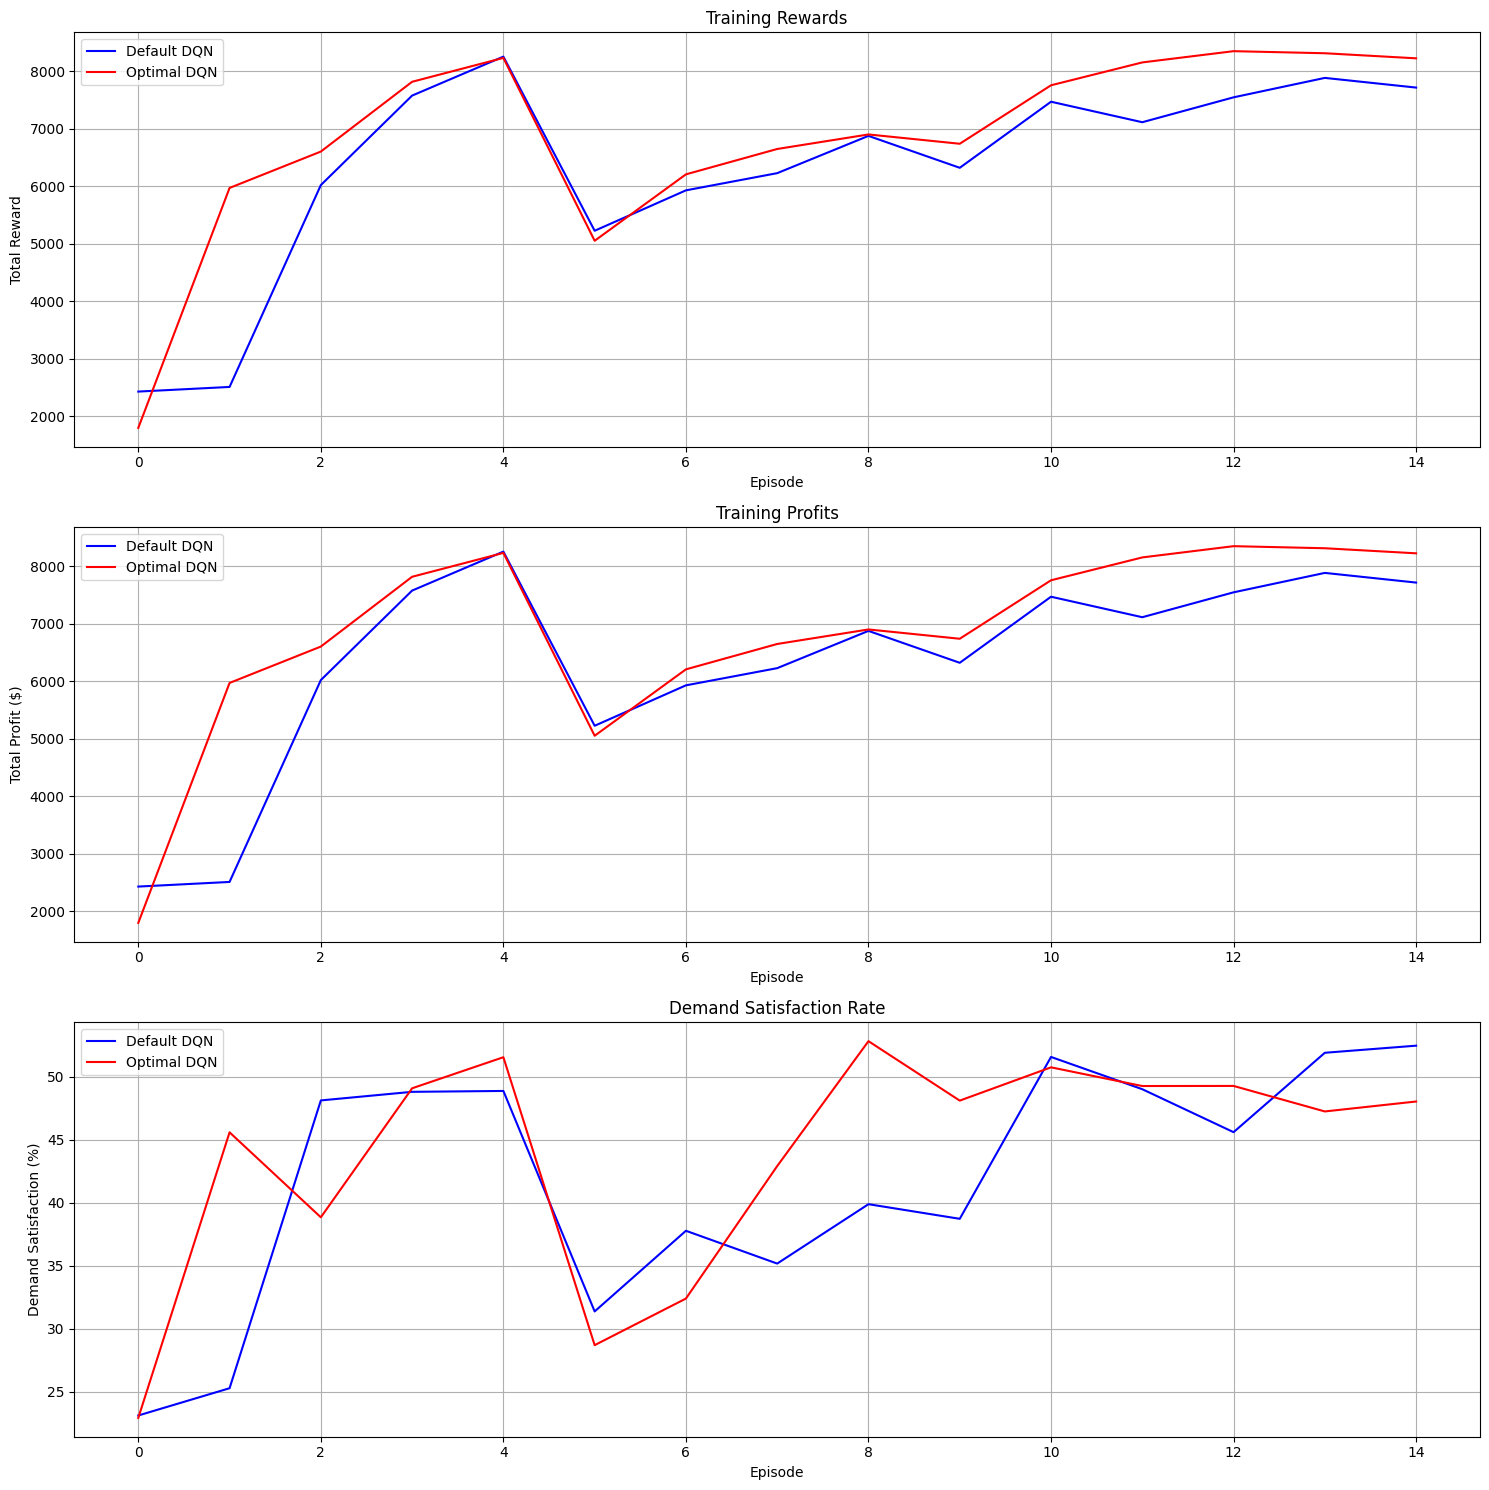


Testing in Standard Environment:

Testing Default DQN Agent:
[--------------------------------------------------]   0%
[==================================================] 100% | Test Episode 3/3 | Reward: 6646.52 | Profit: 6646.52 | Demand Satisfaction: 47.14% | Price-Action Correlation: 0.02

Test Results for Default DQN Agent:
Average Reward: 7077.63 ± 350.47
Average Profit: 7077.63 ± 350.47
Average Demand Satisfaction: 47.35%
Average Price-Action Correlation: 0.16

Testing Optimal DQN Agent:
[--------------------------------------------------]   0%
[==================================================] 100% | Test Episode 3/3 | Reward: 8378.41 | Profit: 8378.41 | Demand Satisfaction: 48.92% | Price-Action Correlation: 0.18

Test Results for Optimal DQN Agent:
Average Reward: 8341.60 ± 132.82
Average Profit: 8341.60 ± 132.82
Average Demand Satisfaction: 49.65%
Average Price-Action Correlation: 0.11

Testing in Extreme Environment:

Testing Default DQN Agent Robustness in Extreme Envi

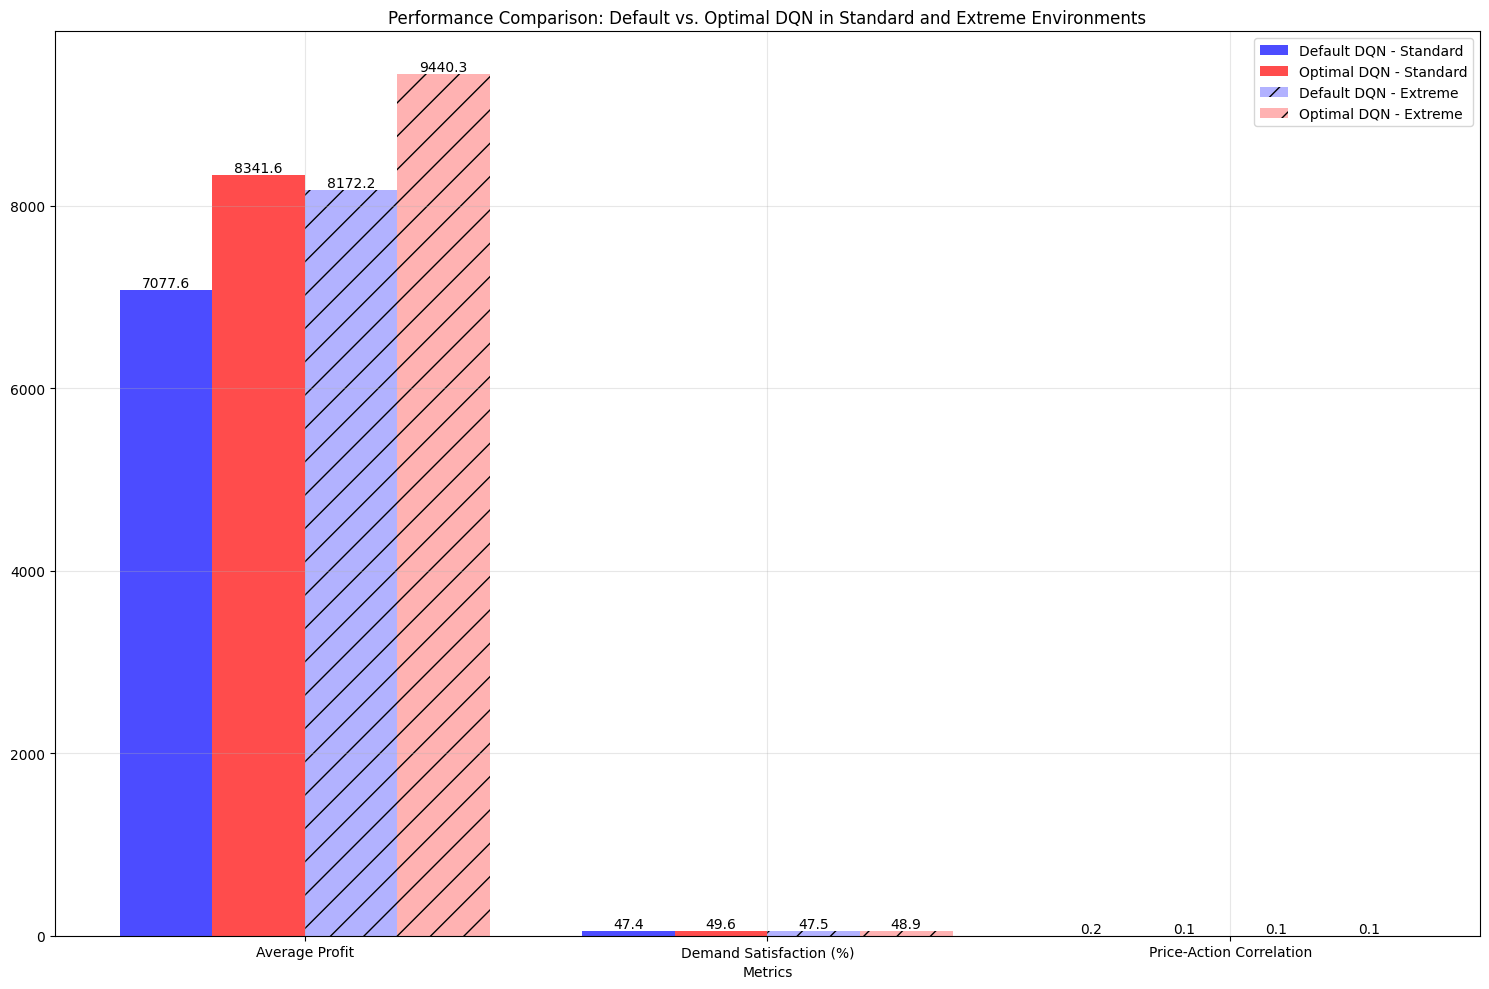

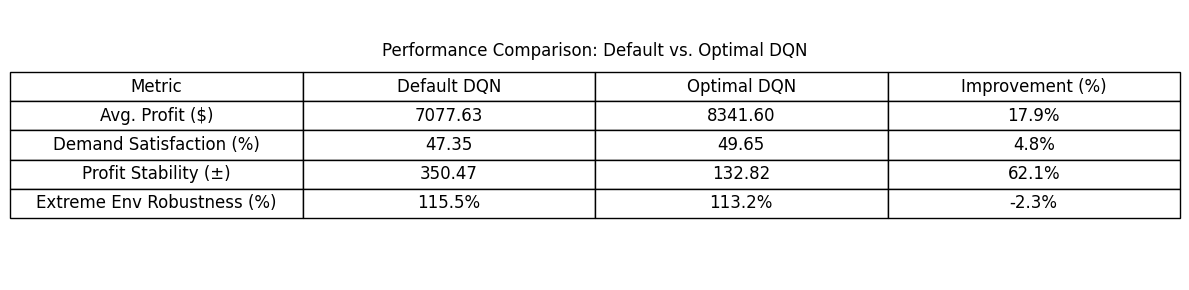


Visualizing Default DQN Agent Behavior:


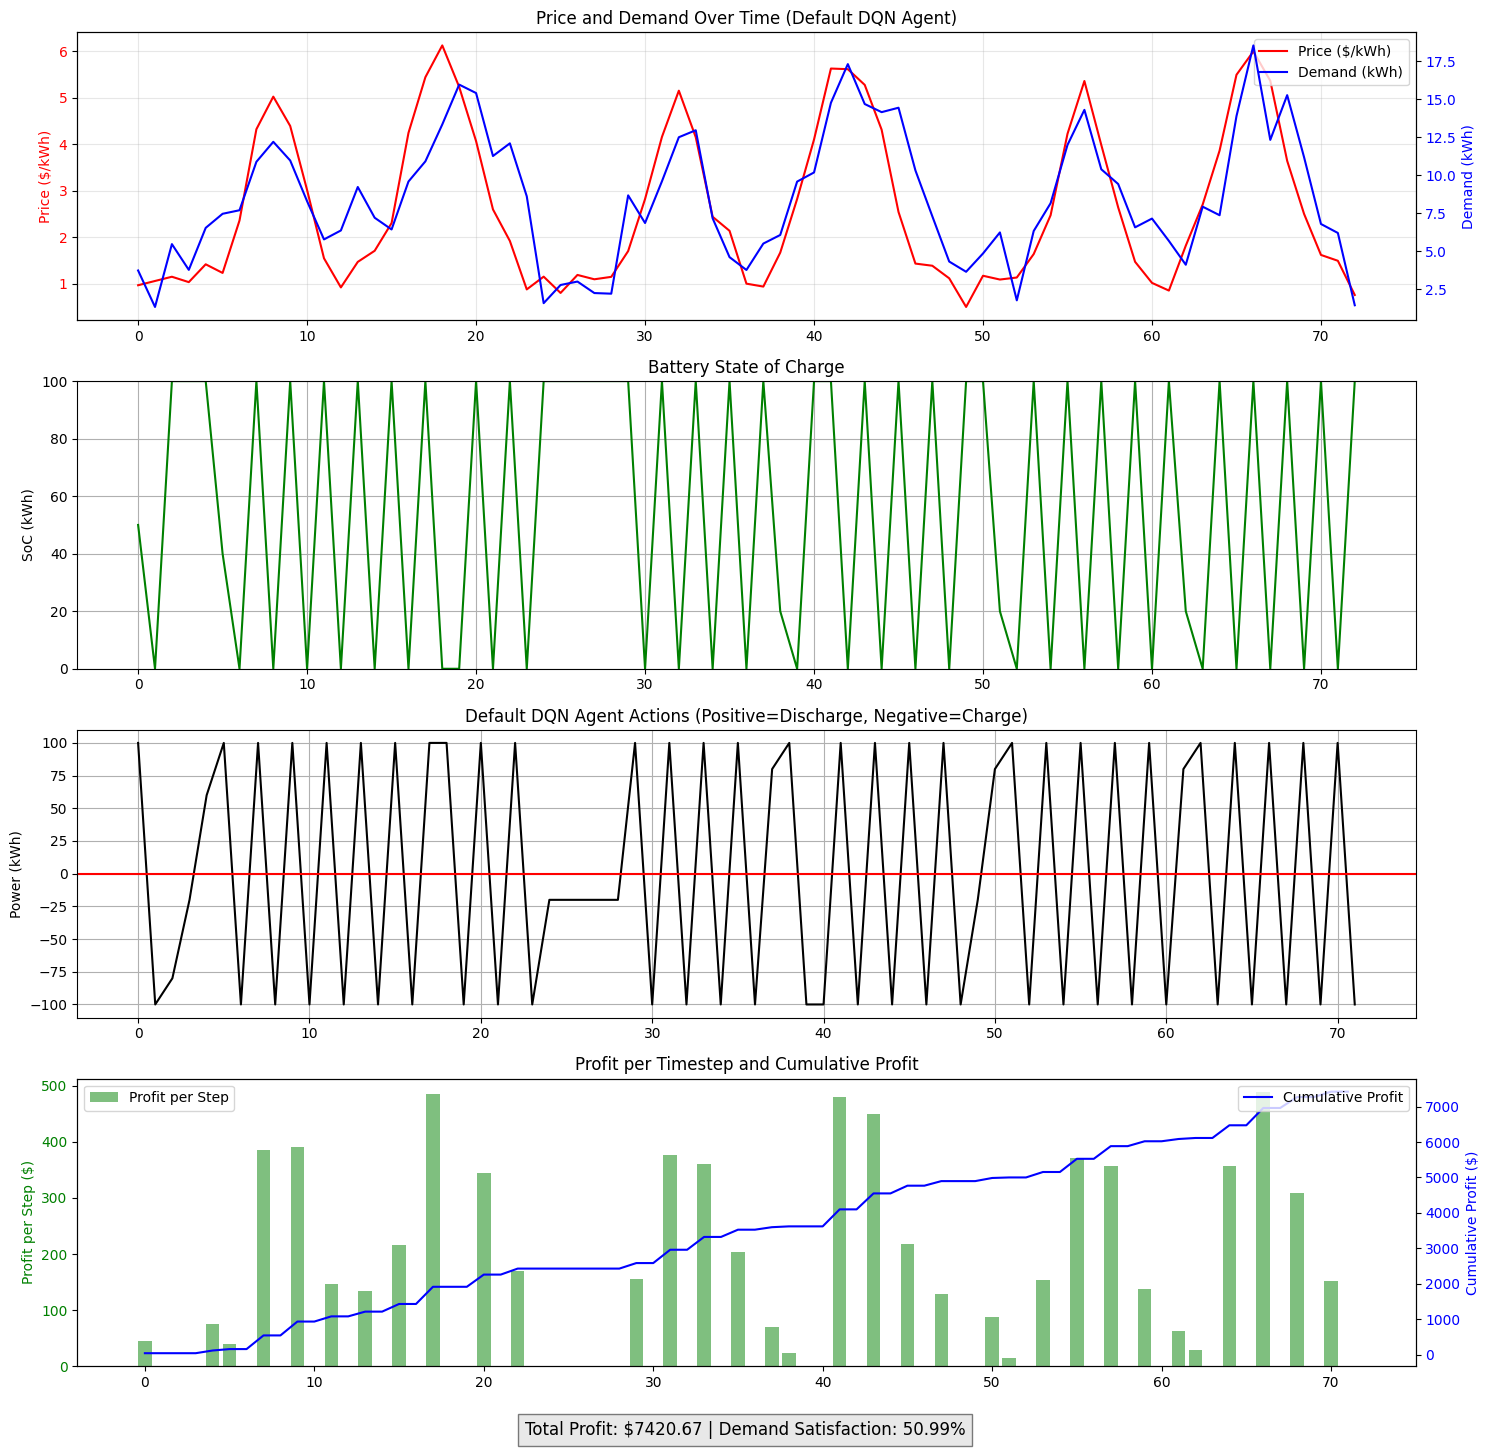


Visualizing Optimal DQN Agent Behavior:


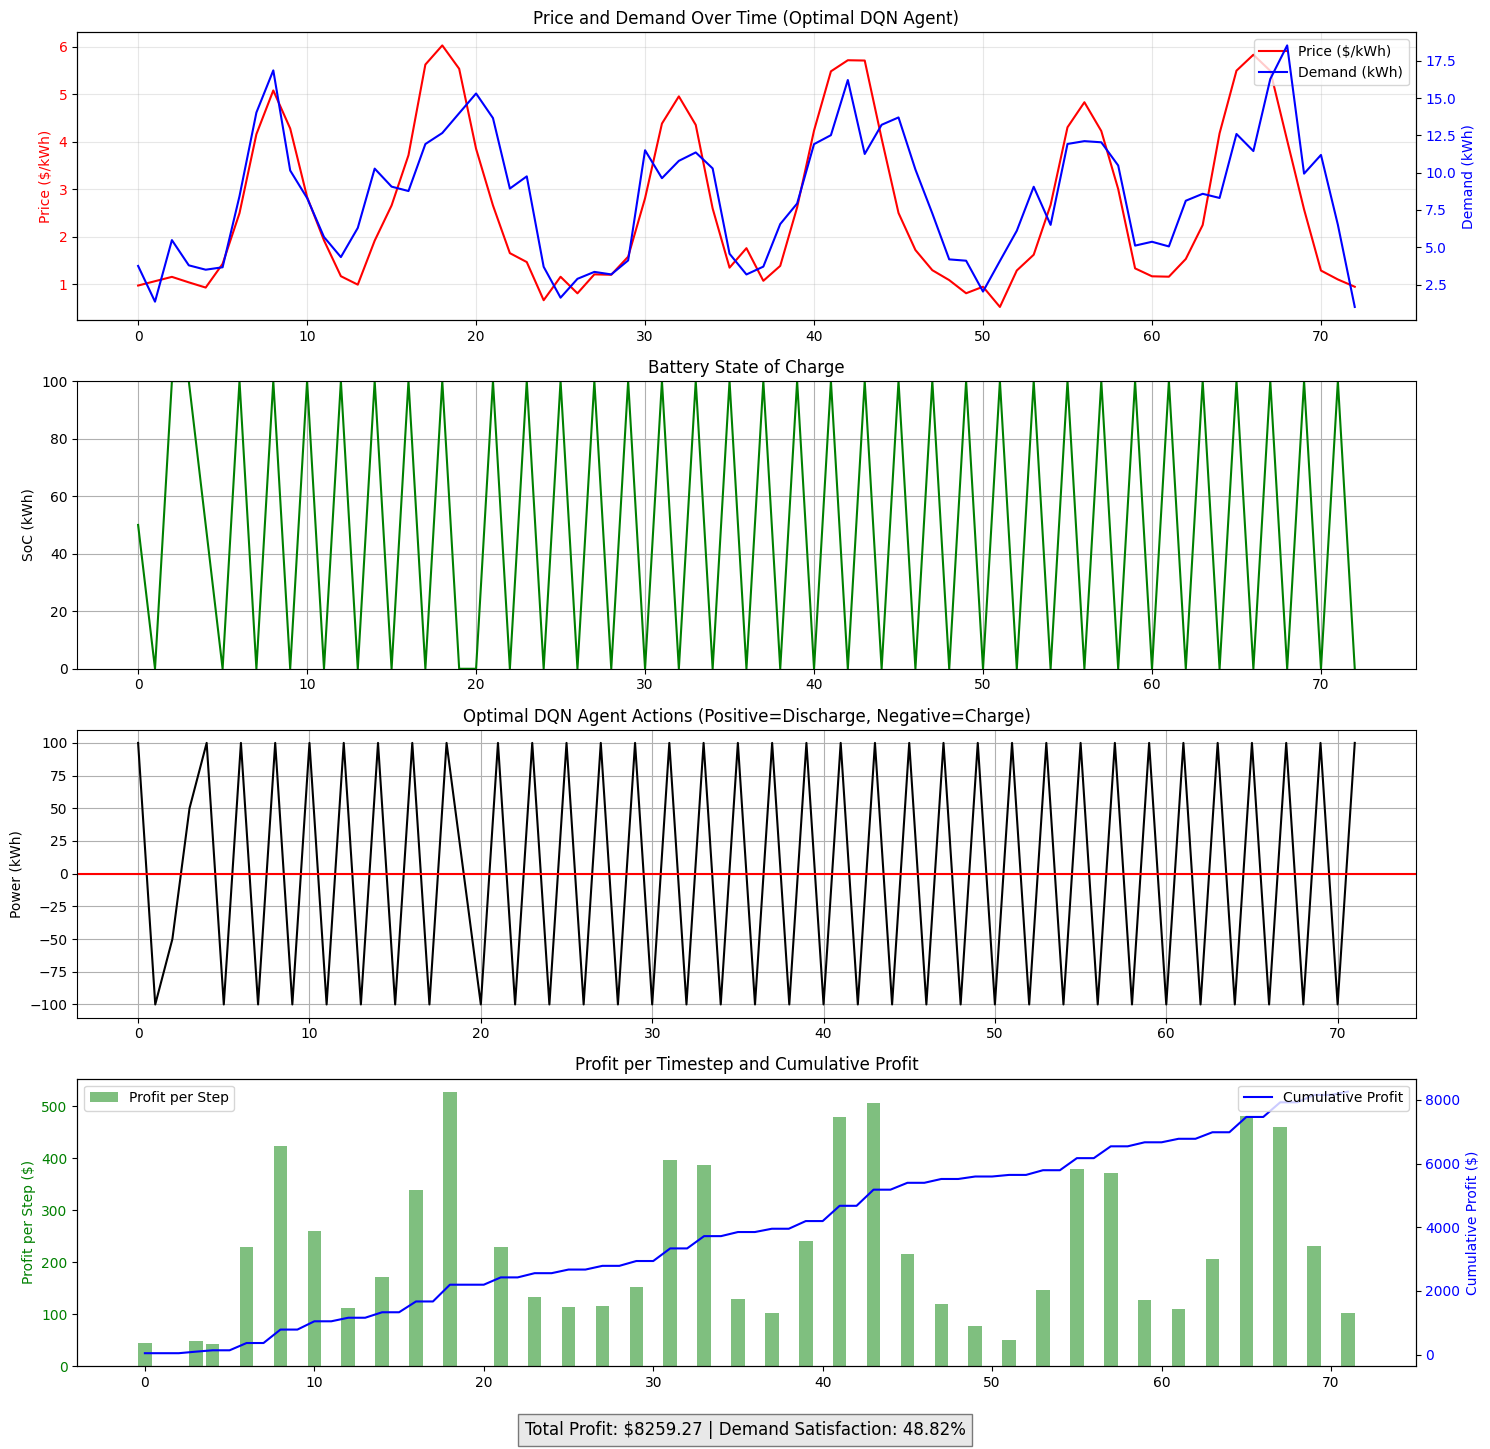


Comparing Agent Behaviors:


/usr/local/lib/python3.11/dist-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


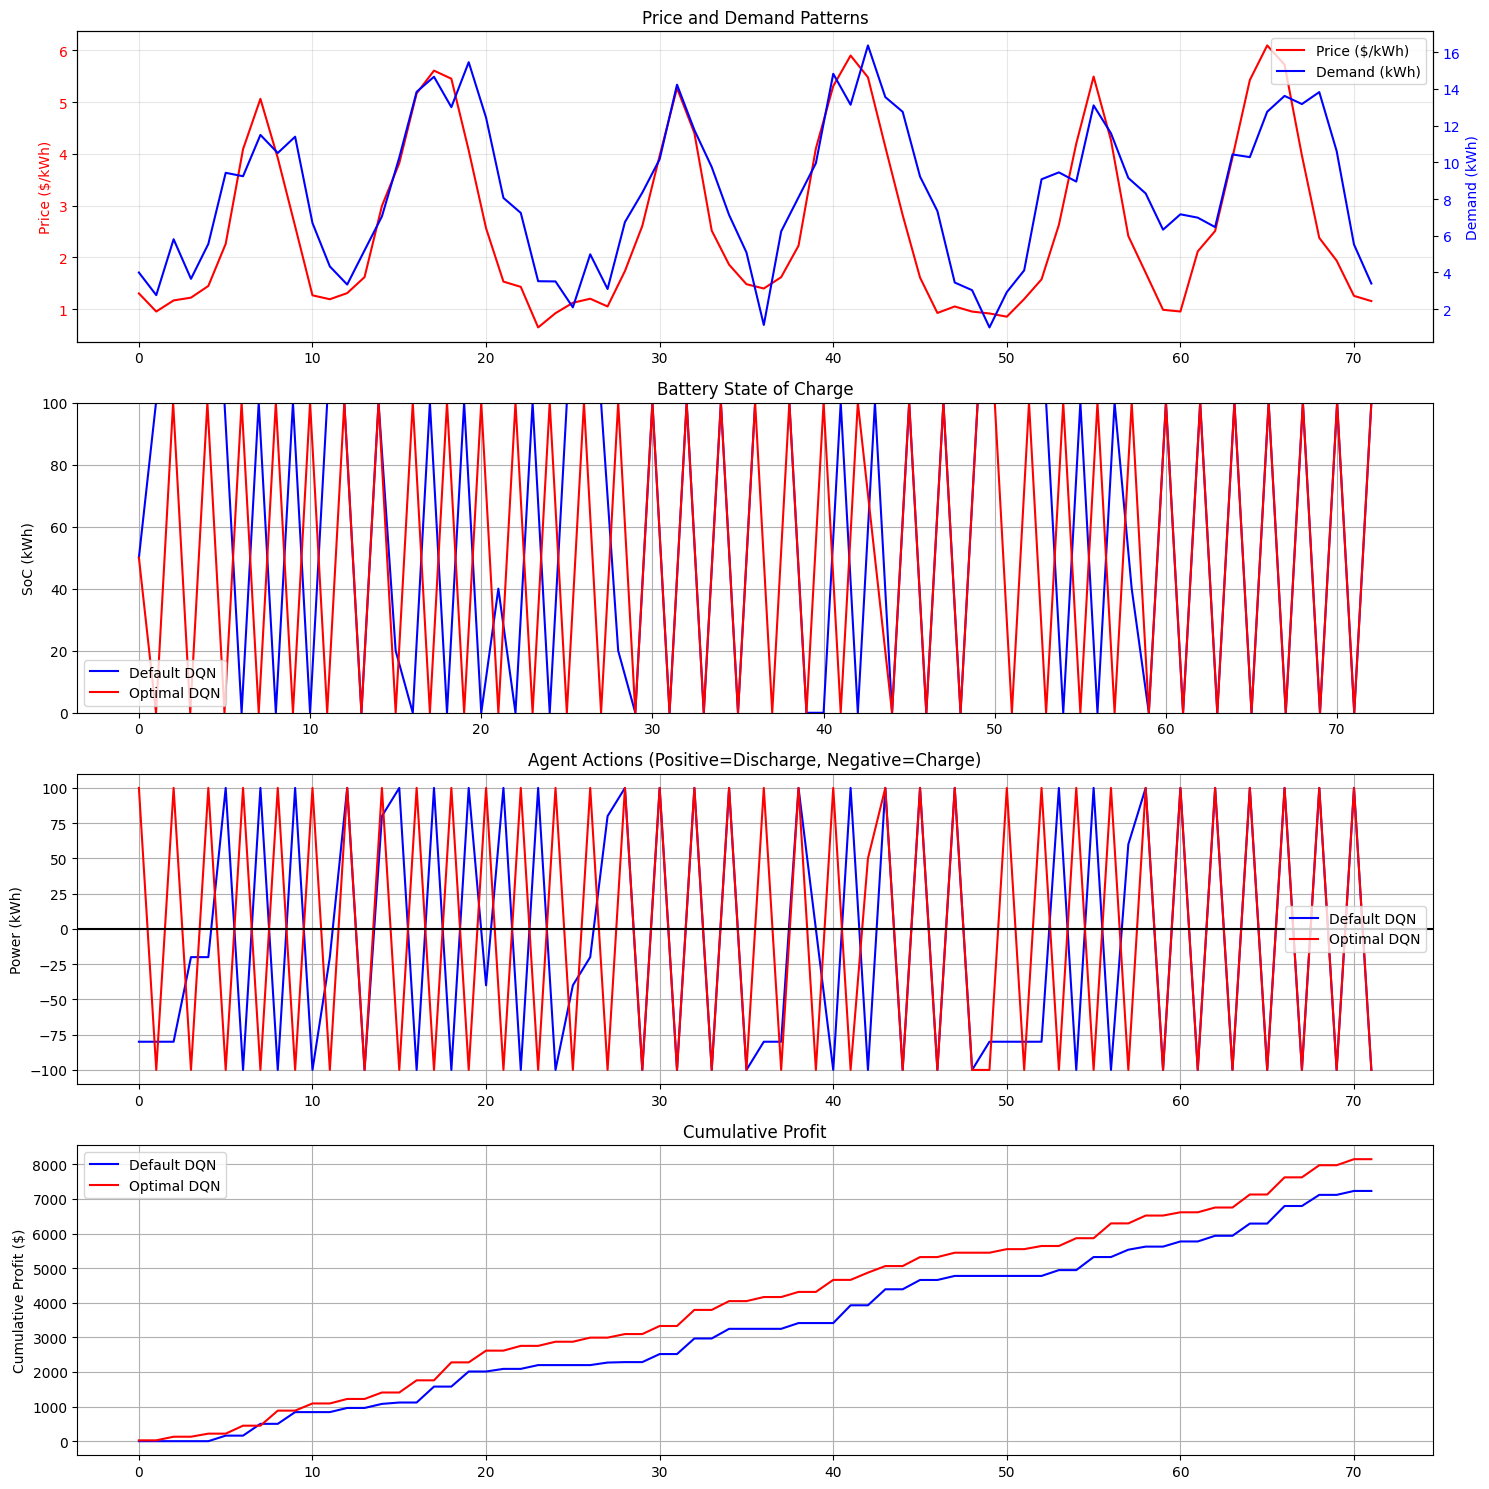


Direct Behavior Comparison:
Default DQN Final Profit: $7232.63
Optimal DQN Final Profit: $8150.81
Profit Improvement: 12.7%

Comparison Summary:
Profit Improvement: 17.9%
Demand Satisfaction Improvement: 4.8%
Profit Stability Improvement: 62.1%

Robustness (% of profit maintained in extreme environment):
Default DQN: 115.5%
Optimal DQN: 113.2%

The Default DQN agent is 2.3% more robust to extreme conditions


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from datetime import timedelta

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Environment parameters - MATCH ORIGINAL EXACTLY
BATTERY_CAPACITY = 100
STEPS_PER_EPISODE = 24 * 3  # 3 days exactly as in original
STATE_SIZE = 3  # SoC, Demand, Price
EPOCHS = 15   # Limited training epochs
TEST_EPISODES = 3  # Number of test episodes

# Default parameters (original)
DEFAULT_PARAMS = {
    'learning_rate': 0.001,
    'gamma': 0.99,
    'epsilon': 1.0,
    'epsilon_decay': 0.99,
    'epsilon_min': 0.05,
    'batch_size': 64,
    'memory_size': 10000,
    'action_size': 11
}

# Optimal parameters from GA
OPTIMAL_PARAMS = {
    'learning_rate': 0.009872574847428997,
    'gamma': 0.9333925119131871,
    'epsilon': 1.0,
    'epsilon_decay': 0.9893348835253262,
    'epsilon_min': 0.021314326575762398,
    'batch_size': 16,
    'memory_size': 2000,
    'action_size': 5
}

def ensure_scalar(value):
    """Ensure a value is a scalar (for consistent reward and action handling)"""
    if isinstance(value, np.ndarray):
        if value.size == 1:
            return value.item()
        else:
            return float(value[0])
    return float(value)

def train_dqn(env, agent, agent_type="Default", episodes=EPOCHS):
    """
    Train a DQN agent.

    Args:
        env: The environment
        agent: The DQN agent
        agent_type: The type of agent (Default or Optimal)
        episodes: Number of episodes to train

    Returns:
        dict: Performance metrics including rewards, profits, and more
    """
    rewards = []
    profits = []
    demand_satisfaction_rates = []
    start_time = time.time()

    print(f"\nTraining {agent_type} DQN Agent:")
    print("[" + "-" * 50 + "]   0% | Time elapsed: 00:00:00")

    # Pre-fill memory with some random experiences
    print("Pre-filling replay memory with random experiences...")
    state, _ = env.reset(seed=42)  # Use fixed seed for reproducibility
    for _ in range(min(agent.batch_size * 2, agent.memory.maxlen // 10)):
        action = np.random.uniform(low=-BATTERY_CAPACITY, high=BATTERY_CAPACITY)
        action_index = np.random.randint(0, agent.action_size)
        next_state, reward, terminated, truncated, _ = env.step(np.array([action]))
        agent.remember(state, action_index, ensure_scalar(reward), next_state, terminated or truncated)
        if terminated or truncated:
            state, _ = env.reset(seed=42)  # Keep seed consistent
        else:
            state = next_state
    print("Memory pre-filling complete.")

    for episode in range(1, episodes + 1):
        episode_start_time = time.time()
        # Don't use fixed seed for actual training, but use same seed for both agents
        np.random.seed(episode+1000)  # Different seed each episode, but same for both agents
        state, _ = env.reset()
        total_reward = 0
        total_demand = 0
        demand_met = 0

        for step in range(STEPS_PER_EPISODE):
            # Choose action
            action, action_index = agent.act(state)

            # Take step
            next_state, reward, terminated, truncated, info = env.step(np.array([action]))

            # Ensure reward is a scalar
            reward = ensure_scalar(reward)

            # Store in replay memory
            agent.remember(state, action_index, reward, next_state, terminated or truncated)

            # Track demand satisfaction
            total_demand += info['demand']
            if info['actual_action'] > 0:  # If discharging
                demand_met += min(info['actual_action'], info['demand'])

            # Learn from experience (only if we have enough samples)
            if len(agent.memory) >= agent.batch_size:
                agent.replay()

            # Update state and reward
            state = next_state
            total_reward += reward

            if terminated or truncated:
                break

        # Update target network periodically
        if episode % 5 == 0:
            agent.update_target_model()

        # Calculate demand satisfaction rate
        satisfaction_rate = (demand_met / total_demand * 100) if total_demand > 0 else 0

        # Record metrics
        rewards.append(total_reward)
        total_profit = sum(env.profit_history)
        profits.append(total_profit)
        demand_satisfaction_rates.append(satisfaction_rate)

        # Print progress
        progress = episode / episodes
        progress_bar = "[" + "=" * int(50 * progress) + "-" * (50 - int(50 * progress)) + "]"
        elapsed_time = time.time() - start_time
        episode_time = time.time() - episode_start_time
        eta = (elapsed_time / episode) * (episodes - episode) if episode > 0 else 0

        print(f"\r{progress_bar} {progress*100:3.0f}% | Episode {episode}/{episodes} | " +
              f"Reward: {total_reward:.2f} | Profit: {total_profit:.2f} | " +
              f"Demand Satisfaction: {satisfaction_rate:.2f}% | Epsilon: {agent.epsilon:.4f} | " +
              f"Episode time: {episode_time:.2f}s | " +
              f"Time: {str(timedelta(seconds=int(elapsed_time)))} | " +
              f"ETA: {str(timedelta(seconds=int(eta)))}", end="")

        # Save model every 5 episodes
        if episode % 5 == 0:
            agent.save(f"models/{agent_type.lower()}_dqn_model_{episode}.h5")

    print(f"\n{agent_type} DQN Training completed!")
    total_time = time.time() - start_time
    print(f"Total training time: {str(timedelta(seconds=int(total_time)))}")

    return {
        "rewards": rewards,
        "profits": profits,
        "demand_satisfaction_rates": demand_satisfaction_rates,
        "training_time": total_time
    }

def test_agent(env, agent, agent_type, episodes=TEST_EPISODES):
    """
    Test an agent on the environment.

    Args:
        env: The environment
        agent: The agent to test
        agent_type: String indicating agent type
        episodes: Number of episodes to test

    Returns:
        dict: Performance metrics including rewards, profits, demand satisfaction, etc.
    """
    total_rewards = []
    total_profits = []
    demand_satisfaction_rates = []
    price_correlations = []  # Correlation between price and action

    print(f"\nTesting {agent_type} DQN Agent:")
    print("[" + "-" * 50 + "]   0%")

    for episode in range(1, episodes + 1):
        # Use same seed for fair comparison between agents
        np.random.seed(episode+2000)  # Different from training seeds
        state, _ = env.reset()
        episode_reward = 0
        total_demand = 0
        demand_met = 0

        # For price-action correlation
        prices = []
        actions = []

        for step in range(STEPS_PER_EPISODE):
            # Choose action
            action, _ = agent.act(state)

            # Track current price
            prices.append(float(state[2]))  # Price is the third state component

            # Take step
            next_state, reward, terminated, truncated, info = env.step(np.array([action]))

            # Ensure reward is a scalar
            reward = ensure_scalar(reward)

            # Track action taken (actual action after environment processing)
            actual_action = ensure_scalar(info['actual_action'])
            actions.append(actual_action)

            # Track demand satisfaction
            total_demand += info['demand']
            if actual_action > 0:  # If discharging
                demand_met += min(actual_action, info['demand'])

            # Update state and reward
            state = next_state
            episode_reward += reward

            if terminated or truncated:
                break

        # Calculate demand satisfaction rate
        demand_satisfaction = (demand_met / total_demand * 100) if total_demand > 0 else 0

        # Calculate correlation between price and discharge actions
        try:
            # Filter to only include discharge actions (positive values)
            discharge_indices = [i for i, a in enumerate(actions) if a > 0]

            if len(discharge_indices) > 1:
                discharge_prices = np.array([prices[i] for i in discharge_indices])
                discharge_actions = np.array([actions[i] for i in discharge_indices])

                # Calculate correlation
                corr_matrix = np.corrcoef(discharge_prices, discharge_actions)
                if corr_matrix.shape == (2, 2):  # Ensure valid correlation matrix
                    price_action_corr = float(corr_matrix[0, 1])
                    if np.isnan(price_action_corr):
                        price_action_corr = 0.0
                else:
                    price_action_corr = 0.0
            else:
                price_action_corr = 0.0  # Not enough discharge actions
        except Exception as e:
            print(f"Error calculating correlation: {e}")
            price_action_corr = 0.0

        # Collect episode metrics
        total_rewards.append(episode_reward)
        total_profits.append(float(sum(env.profit_history)))
        demand_satisfaction_rates.append(demand_satisfaction)
        price_correlations.append(price_action_corr)

        # Print progress
        progress = episode / episodes
        progress_bar = "[" + "=" * int(50 * progress) + "-" * (50 - int(50 * progress)) + "]"
        print(f"\r{progress_bar} {progress*100:3.0f}% | Test Episode {episode}/{episodes} | " +
              f"Reward: {episode_reward:.2f} | Profit: {sum(env.profit_history):.2f} | " +
              f"Demand Satisfaction: {demand_satisfaction:.2f}% | " +
              f"Price-Action Correlation: {price_action_corr:.2f}", end="")

    print("\n")

    # Calculate average metrics
    avg_reward = float(np.mean(total_rewards))
    avg_profit = float(np.mean(total_profits))
    avg_demand_satisfaction = float(np.mean(demand_satisfaction_rates))
    avg_price_correlation = float(np.mean(price_correlations))

    # Calculate standard deviations (stability metrics)
    std_reward = float(np.std(total_rewards))
    std_profit = float(np.std(total_profits))

    print(f"Test Results for {agent_type} DQN Agent:")
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Average Profit: {avg_profit:.2f} ± {std_profit:.2f}")
    print(f"Average Demand Satisfaction: {avg_demand_satisfaction:.2f}%")
    print(f"Average Price-Action Correlation: {avg_price_correlation:.2f}")

    return {
        "avg_reward": avg_reward,
        "avg_profit": avg_profit,
        "avg_demand_satisfaction": avg_demand_satisfaction,
        "avg_price_correlation": avg_price_correlation,
        "std_reward": std_reward,
        "std_profit": std_profit,
        "rewards": total_rewards,
        "profits": total_profits,
        "demand_satisfaction_rates": demand_satisfaction_rates,
        "price_correlations": price_correlations
    }

def test_robustness(env, agent, agent_type, episodes=TEST_EPISODES):
    """
    Test an agent on the extreme environment to assess robustness.

    Args:
        env: The extreme environment
        agent: The agent to test
        agent_type: String indicating agent type
        episodes: Number of episodes to test

    Returns:
        dict: Performance metrics in extreme environment
    """
    print(f"\nTesting {agent_type} DQN Agent Robustness in Extreme Environment:")
    return test_agent(env, agent, agent_type, episodes)

def visualize_agent_behavior(env, agent, agent_type, filename_suffix=""):
    """
    Visualize agent behavior in the environment.

    Args:
        env: The environment
        agent: The agent
        agent_type: String indicating agent type
        filename_suffix: Optional suffix for the saved file name
    """
    # Use fixed seed for consistent environment
    np.random.seed(42)
    state, _ = env.reset()

    # Run one episode
    for step in range(STEPS_PER_EPISODE):
        # Choose action
        action, _ = agent.act(state)

        # Take step
        state, reward, terminated, truncated, info = env.step(np.array([action]))

        if terminated or truncated:
            break

    # Calculate metrics
    total_profit = float(sum(env.profit_history))

    # Calculate demand satisfaction
    total_demand = sum(env.demand_history)
    demand_met = 0
    for i, action in enumerate(env.action_history):
        if action > 0:  # If discharging
            demand = env.demand_history[i] if i < len(env.demand_history) else 0
            demand_met += min(action, demand)

    demand_satisfaction = (demand_met / total_demand * 100) if total_demand > 0 else 0

    # Plot results
    plt.figure(figsize=(15, 15))

    # Plot price and demand with dual y-axes
    ax1 = plt.subplot(4, 1, 1)
    plt.title(f'Price and Demand Over Time ({agent_type} DQN Agent)')

    # Price on left y-axis
    line1, = ax1.plot(env.price_history, 'r-', label='Price ($/kWh)')
    ax1.set_ylabel('Price ($/kWh)', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.grid(True, alpha=0.3)

    # Demand on right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(env.demand_history, 'b-', label='Demand (kWh)')
    ax2.set_ylabel('Demand (kWh)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Combined legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    # Plot battery SoC
    plt.subplot(4, 1, 2)
    plt.title('Battery State of Charge')
    plt.plot(env.soc_history, 'g-')
    plt.ylim(0, env.battery_capacity)
    plt.ylabel('SoC (kWh)')
    plt.grid(True)

    # Plot actions
    plt.subplot(4, 1, 3)
    plt.title(f'{agent_type} DQN Agent Actions (Positive=Discharge, Negative=Charge)')
    plt.plot(env.action_history, 'k-')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.ylabel('Power (kWh)')
    plt.grid(True)

    # Plot profit and cumulative profit
    plt.subplot(4, 1, 4)
    plt.title('Profit per Timestep and Cumulative Profit')
    plt.bar(range(len(env.profit_history)), env.profit_history, color='g', alpha=0.5, label='Profit per Step')

    # Cumulative profit on right y-axis
    ax3 = plt.gca()
    ax4 = ax3.twinx()
    cumulative_profit = np.cumsum(env.profit_history)
    ax4.plot(cumulative_profit, 'b-', label='Cumulative Profit')
    ax4.set_ylabel('Cumulative Profit ($)', color='b')
    ax4.tick_params(axis='y', labelcolor='b')

    # Combined legend
    ax3.set_ylabel('Profit per Step ($)', color='g')
    ax3.tick_params(axis='y', labelcolor='g')
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper right')

    # Add a text box with metrics
    plt.figtext(0.5, 0.01,
                f'Total Profit: ${total_profit:.2f} | Demand Satisfaction: {demand_satisfaction:.2f}%',
                ha='center', fontsize=12,
                bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust layout to make room for text
    filename = f'figures/{agent_type.lower()}_dqn_behavior'
    if filename_suffix:
        filename += f'_{filename_suffix}'
    plt.savefig(f'{filename}.png')
    plt.show()

def compare_learning_curves(default_metrics, optimal_metrics):
    """
    Plot comparative learning curves for both agents.

    Args:
        default_metrics: Dictionary with Default DQN training metrics
        optimal_metrics: Dictionary with Optimal DQN training metrics
    """
    plt.figure(figsize=(15, 15))

    # Plot rewards
    plt.subplot(3, 1, 1)
    plt.plot(default_metrics['rewards'], 'b-', label='Default DQN')
    plt.plot(optimal_metrics['rewards'], 'r-', label='Optimal DQN')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)

    # Plot profits
    plt.subplot(3, 1, 2)
    plt.plot(default_metrics['profits'], 'b-', label='Default DQN')
    plt.plot(optimal_metrics['profits'], 'r-', label='Optimal DQN')
    plt.title('Training Profits')
    plt.xlabel('Episode')
    plt.ylabel('Total Profit ($)')
    plt.legend()
    plt.grid(True)

    # Plot demand satisfaction rate
    plt.subplot(3, 1, 3)
    plt.plot(default_metrics['demand_satisfaction_rates'], 'b-', label='Default DQN')
    plt.plot(optimal_metrics['demand_satisfaction_rates'], 'r-', label='Optimal DQN')
    plt.title('Demand Satisfaction Rate')
    plt.xlabel('Episode')
    plt.ylabel('Demand Satisfaction (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('figures/dqn_comparison_learning_curves.png')
    plt.show()

def visualize_test_results(default_std_results, optimal_std_results, default_extreme_results, optimal_extreme_results):
    """
    Visualize test results for both agents in standard and extreme environments.

    Args:
        default_std_results: Default DQN results in standard environment
        optimal_std_results: Optimal DQN results in standard environment
        default_extreme_results: Default DQN results in extreme environment
        optimal_extreme_results: Optimal DQN results in extreme environment
    """
    # Create bar chart comparison
    plt.figure(figsize=(15, 10))

    # Labels for the bar groups
    labels = ['Average Profit', 'Demand Satisfaction (%)', 'Price-Action Correlation']

    # Data for each metric
    default_std_data = [default_std_results['avg_profit'], default_std_results['avg_demand_satisfaction'], default_std_results['avg_price_correlation']]
    optimal_std_data = [optimal_std_results['avg_profit'], optimal_std_results['avg_demand_satisfaction'], optimal_std_results['avg_price_correlation']]
    default_ext_data = [default_extreme_results['avg_profit'], default_extreme_results['avg_demand_satisfaction'], default_extreme_results['avg_price_correlation']]
    optimal_ext_data = [optimal_extreme_results['avg_profit'], optimal_extreme_results['avg_demand_satisfaction'], optimal_extreme_results['avg_price_correlation']]

    # Width of each bar
    bar_width = 0.2

    # Position of bars on x-axis
    r1 = np.arange(len(labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]

    # Create bars
    plt.bar(r1, default_std_data, width=bar_width, label='Default DQN - Standard', color='blue', alpha=0.7)
    plt.bar(r2, optimal_std_data, width=bar_width, label='Optimal DQN - Standard', color='red', alpha=0.7)
    plt.bar(r3, default_ext_data, width=bar_width, label='Default DQN - Extreme', color='blue', alpha=0.3, hatch='/')
    plt.bar(r4, optimal_ext_data, width=bar_width, label='Optimal DQN - Extreme', color='red', alpha=0.3, hatch='/')

    # Add labels and title
    plt.xlabel('Metrics')
    plt.xticks([r + bar_width*1.5 for r in range(len(labels))], labels)
    plt.title('Performance Comparison: Default vs. Optimal DQN in Standard and Extreme Environments')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value labels on top of bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{height:.1f}', ha='center', va='bottom')

    # Get all the bar containers and add labels
    for bars in plt.gca().containers:
        add_labels(bars)

    plt.tight_layout()
    plt.savefig('figures/dqn_comparison_test_results.png')
    plt.show()

    # Create a table with detailed metrics
    plt.figure(figsize=(12, 3))
    plt.axis('off')

    # Calculate improvement percentages
    profit_improvement = (optimal_std_results['avg_profit'] / default_std_results['avg_profit'] - 1) * 100
    demand_improvement = (optimal_std_results['avg_demand_satisfaction'] / default_std_results['avg_demand_satisfaction'] - 1) * 100

    # Default robustness = % of profit maintained in extreme environment
    default_robustness = (default_extreme_results['avg_profit'] / default_std_results['avg_profit']) * 100
    optimal_robustness = (optimal_extreme_results['avg_profit'] / optimal_std_results['avg_profit']) * 100

    robustness_improvement = optimal_robustness - default_robustness

    table_data = [
        ['Metric', 'Default DQN', 'Optimal DQN', 'Improvement (%)'],
        ['Avg. Profit ($)', f"{default_std_results['avg_profit']:.2f}", f"{optimal_std_results['avg_profit']:.2f}", f"{profit_improvement:.1f}%"],
        ['Demand Satisfaction (%)', f"{default_std_results['avg_demand_satisfaction']:.2f}", f"{optimal_std_results['avg_demand_satisfaction']:.2f}", f"{demand_improvement:.1f}%"],
        ['Profit Stability (±)', f"{default_std_results['std_profit']:.2f}", f"{optimal_std_results['std_profit']:.2f}", f"{(1 - optimal_std_results['std_profit']/default_std_results['std_profit'])*100:.1f}%"],
        ['Extreme Env Robustness (%)', f"{default_robustness:.1f}%", f"{optimal_robustness:.1f}%", f"{robustness_improvement:.1f}%"]
    ]

    table = plt.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    # Add title
    plt.title('Performance Comparison: Default vs. Optimal DQN', y=0.8)

    plt.tight_layout()
    plt.savefig('figures/dqn_comparison_metrics_table.png')
    plt.show()

def compare_behavior(default_agent, optimal_agent):
    """
    Compare behavior of default and optimal DQN agents on the same environment instance.

    Args:
        default_agent: Default DQN agent
        optimal_agent: Optimal DQN agent
    """
    # Set fixed seed for reproducibility
    SEED = 42
    np.random.seed(SEED)

    # Store metrics for both agents
    agent_names = ['Default DQN', 'Optimal DQN']
    colors = ['blue', 'red']

    # Run environment once to get price/demand patterns
    env_setup = ElectricityMarketEnv(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)
    state, _ = env_setup.reset(seed=SEED)
    price_history = []
    demand_history = []

    for _ in range(STEPS_PER_EPISODE):
        _, _, terminated, truncated, _ = env_setup.step(np.array([0]))  # No-op action
        price_history.append(env_setup.price_history[-1])
        demand_history.append(env_setup.demand_history[-1])
        if terminated or truncated:
            break

    # Collect behavior data for each agent
    all_actions = []
    all_soc = []
    all_profits = []

    for agent_idx, agent in enumerate([default_agent, optimal_agent]):
        # Create new environment with the same seed
        env = ElectricityMarketEnv(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)
        state, _ = env.reset(seed=SEED)  # Same seed for both agents

        actions = []
        soc = [env.state[0]]  # Initial SoC

        for step in range(STEPS_PER_EPISODE):
            # Choose action
            action, _ = agent.act(state)

            # Take step
            next_state, _, terminated, truncated, _ = env.step(np.array([action]))

            # Track metrics
            actions.append(float(env.action_history[-1]))
            soc.append(float(env.soc_history[-1]))

            # Update state
            state = next_state

            if terminated or truncated:
                break

        # Store agent metrics
        all_actions.append(actions)
        all_soc.append(soc)
        all_profits.append(np.cumsum(env.profit_history))

    # Plot comparison
    plt.figure(figsize=(15, 15))

    # Plot price and demand patterns
    ax1 = plt.subplot(4, 1, 1)
    plt.title('Price and Demand Patterns')

    # Price on left y-axis
    line1, = ax1.plot(price_history, 'r-', label='Price ($/kWh)')
    ax1.set_ylabel('Price ($/kWh)', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.grid(True, alpha=0.3)

    # Demand on right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(demand_history, 'b-', label='Demand (kWh)')
    ax2.set_ylabel('Demand (kWh)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    # Combined legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper right')

    # Plot SoC for both agents
    plt.subplot(4, 1, 2)
    plt.title('Battery State of Charge')
    for i, soc in enumerate(all_soc):
        plt.plot(soc, '-', color=colors[i], label=agent_names[i])
    plt.ylim(0, BATTERY_CAPACITY)
    plt.ylabel('SoC (kWh)')
    plt.grid(True)
    plt.legend()

    # Plot actions for both agents
    plt.subplot(4, 1, 3)
    plt.title('Agent Actions (Positive=Discharge, Negative=Charge)')
    for i, actions in enumerate(all_actions):
        plt.plot(actions, '-', color=colors[i], label=agent_names[i])
    plt.axhline(y=0, color='black', linestyle='-')
    plt.ylabel('Power (kWh)')
    plt.grid(True)
    plt.legend()

    # Plot cumulative profit for both agents
    plt.subplot(4, 1, 4)
    plt.title('Cumulative Profit')
    for i, profits in enumerate(all_profits):
        plt.plot(profits, '-', color=colors[i], label=agent_names[i])
    plt.ylabel('Cumulative Profit ($)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('figures/dqn_comparison_behavior.png')
    plt.show()

    # Print profit comparison
    final_default_profit = all_profits[0][-1]
    final_optimal_profit = all_profits[1][-1]
    profit_improvement = (final_optimal_profit / final_default_profit - 1) * 100

    print(f"\nDirect Behavior Comparison:")
    print(f"Default DQN Final Profit: ${final_default_profit:.2f}")
    print(f"Optimal DQN Final Profit: ${final_optimal_profit:.2f}")
    print(f"Profit Improvement: {profit_improvement:.1f}%")

def main():
    """Main function to run the comparison"""
    print("=" * 70)
    print("Comparing Default vs Optimal DQN Agents")
    print("=" * 70)

    # Create agents
    default_agent = DQNAgent(
        state_size=STATE_SIZE,
        action_size=DEFAULT_PARAMS['action_size'],
        battery_capacity=BATTERY_CAPACITY,
        learning_rate=DEFAULT_PARAMS['learning_rate'],
        gamma=DEFAULT_PARAMS['gamma'],
        epsilon=DEFAULT_PARAMS['epsilon'],
        epsilon_decay=DEFAULT_PARAMS['epsilon_decay'],
        epsilon_min=DEFAULT_PARAMS['epsilon_min'],
        batch_size=DEFAULT_PARAMS['batch_size'],
        memory_size=DEFAULT_PARAMS['memory_size']
    )

    optimal_agent = DQNAgent(
        state_size=STATE_SIZE,
        action_size=OPTIMAL_PARAMS['action_size'],
        battery_capacity=BATTERY_CAPACITY,
        learning_rate=OPTIMAL_PARAMS['learning_rate'],
        gamma=OPTIMAL_PARAMS['gamma'],
        epsilon=OPTIMAL_PARAMS['epsilon'],
        epsilon_decay=OPTIMAL_PARAMS['epsilon_decay'],
        epsilon_min=OPTIMAL_PARAMS['epsilon_min'],
        batch_size=OPTIMAL_PARAMS['batch_size'],
        memory_size=OPTIMAL_PARAMS['memory_size']
    )

    # Create environments
    std_env_default = ElectricityMarketEnv(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)
    std_env_optimal = ElectricityMarketEnv(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)

    # Train agents - using separate but identical environments
    default_metrics = train_dqn(std_env_default, default_agent, "Default", EPOCHS)
    optimal_metrics = train_dqn(std_env_optimal, optimal_agent, "Optimal", EPOCHS)

    # Compare learning curves
    compare_learning_curves(default_metrics, optimal_metrics)

    # Create fresh environments for testing
    std_env = ElectricityMarketEnv(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)
    extreme_env = ExtremeEnvironment(battery_capacity=BATTERY_CAPACITY, max_steps=STEPS_PER_EPISODE)

    # Test in standard environment
    print("\nTesting in Standard Environment:")
    default_std_results = test_agent(std_env, default_agent, "Default")
    optimal_std_results = test_agent(std_env, optimal_agent, "Optimal")

    # Test in extreme environment
    print("\nTesting in Extreme Environment:")
    default_extreme_results = test_robustness(extreme_env, default_agent, "Default")
    optimal_extreme_results = test_robustness(extreme_env, optimal_agent, "Optimal")

    # Visualize test results
    visualize_test_results(
        default_std_results,
        optimal_std_results,
        default_extreme_results,
        optimal_extreme_results
    )

    # Visualize agent behavior
    print("\nVisualizing Default DQN Agent Behavior:")
    visualize_agent_behavior(std_env, default_agent, "Default", "standard")

    print("\nVisualizing Optimal DQN Agent Behavior:")
    visualize_agent_behavior(std_env, optimal_agent, "Optimal", "standard")

    # Compare agent behavior directly
    print("\nComparing Agent Behaviors:")
    compare_behavior(default_agent, optimal_agent)

    # Print summary
    print("\n" + "=" * 70)
    print("Comparison Summary:")
    print("=" * 70)

    # Calculate improvements
    profit_improvement = (optimal_std_results['avg_profit'] / default_std_results['avg_profit'] - 1) * 100
    demand_improvement = (optimal_std_results['avg_demand_satisfaction'] / default_std_results['avg_demand_satisfaction'] - 1) * 100
    stability_improvement = (1 - optimal_std_results['std_profit'] / default_std_results['std_profit']) * 100

    print(f"Profit Improvement: {profit_improvement:.1f}%")
    print(f"Demand Satisfaction Improvement: {demand_improvement:.1f}%")
    print(f"Profit Stability Improvement: {stability_improvement:.1f}%")

    # Check robustness
    default_robustness = (default_extreme_results['avg_profit'] / default_std_results['avg_profit']) * 100
    optimal_robustness = (optimal_extreme_results['avg_profit'] / optimal_std_results['avg_profit']) * 100

    print(f"\nRobustness (% of profit maintained in extreme environment):")
    print(f"Default DQN: {default_robustness:.1f}%")
    print(f"Optimal DQN: {optimal_robustness:.1f}%")

    if optimal_robustness > default_robustness:
        print(f"\nThe Optimal DQN agent is {optimal_robustness - default_robustness:.1f}% more robust to extreme conditions")
    else:
        print(f"\nThe Default DQN agent is {default_robustness - optimal_robustness:.1f}% more robust to extreme conditions")

    print("=" * 70)

if __name__ == "__main__":
    main()